# University ranks

## Introduction

The goal of this work is to answer the following questions:

* How  do  university  rankings  change  over  time?
* Which  characteristics  of  universities  contribute most to good rankings, or to large changes in the ranking position?
* How do these characteristics correlate with characteristics of cities or countries in which the university islocated?
* Are there predictors for increases or decreases in the rankings?

In the course of this work, these questions will be refined and precised before being answered.

The work is devided in three parts, which correspond to the steps in the data science process. First, we will load all necessary data. This includes also data cleaning. Then the data will be explored using plots and calculating descriptive statistics. The third step will be to model the data using ML models.

Before starting, we need to load the needed packages for data processing and visualisation:

In [1]:
import os
import numpy as np
import glob
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import re

pd.options.display.max_rows = 10

## Step 1: Load the data

We load the CWUR data and the Shanghai data. They are available at https://www.kaggle.com/mylesoneill/world-university-rankings. For the Shanghai data the respective countries of the universities have to be merged.

In [2]:
datapath = "data/university_data/"

#uni rankings
cwur = pd.read_csv(datapath + "/cwurData.csv", header=0)
shanghai = pd.read_csv(datapath + "/shanghaiData.csv", header=0)
times = pd.read_csv(datapath + "/timesData.csv", header=0)

#additional university information
uni2country = pd.read_csv(datapath + "/school_and_country_table.csv", header=0)

#country properties
educ_expenditure = pd.read_csv(datapath + "/education_expenditure_supplementary_data.csv",
                               header=0,
                               quotechar="\"")
nbupc = pd.read_csv("data/nbupc.tsv", header=0, sep="\t", engine='python')
inh = pd.read_csv("data/inh.csv", header=0, sep=",", quotechar = "\"")
hdi = pd.read_csv(datapath + "/Human_Development_Index.csv")
corruption = pd.read_csv(datapath+ "/history.csv")
countr_reg = pd.read_csv(datapath + "/countries_region.csv")

## Step 2: Preprocessing

### 2.1 Removal of irrelevant columns

Certain columns were not needed due to either more data existing in other datasets or the columns being irrelevant.

In [3]:
nbupc = nbupc[["COUNTRY", "ALL"]]
nbupc.columns = ["country", "number of universities"]
nbupc["country"]=nbupc["country"].str.strip()

inh = inh[["Country Name", "2018"]]
inh.columns = ["country", "inhabitants"]

del corruption['Country Code']
del corruption['Region']

countr_reg.drop(countr_reg.columns.difference(['Country','Region']), 1, inplace=True)


shanghai = shanghai[pd.notna(shanghai['university_name'])] #delete one row that is NAs only

### 2.2 Unified Naming of characteristics:

One issue is different naming for certain columns. Analysing and renaming such values is imperative before merging data.

In [4]:
#Rename columns
cwur = cwur.rename(columns={'institution': 'university_name'})
uni2country = uni2country.rename(columns={'school_name': 'university_name'})
countr_reg = countr_reg.rename(columns={'Country': 'country', 'Region': 'region'})
hdi_ref = hdi.rename(columns={'Country': 'country', 'HDI Rank': 'hdi_rank', 'HDI':'hdi'})
corruption_ref = corruption.rename(columns={'CPI 2016 Rank': 'cpi_rank', 'Country': 'country', 'CPI 2012 Score': '2012', 'CPI 2013 Score': '2013', 'CPI 2014 Score': '2014', 'CPI 2015 Score': '2015', 'CPI 2016 Score': '2016'})

#Strip whitespace
hdi_ref['country'] = hdi_ref['country'].str.strip()
educ_expenditure["institute_type"]=educ_expenditure["institute_type"].str.strip()
countr_reg['country'] = countr_reg['country'].str.strip()
countr_reg['region'] = countr_reg['region'].str.strip()
corruption_ref['country'] = corruption_ref['country'].str.strip()

### 2.3 Casting the world_rank columns to int

For visualization and for some ML-algorithms we need to have integer values in the world_rank columns. First, we replace range of numbers by their means, i.e. '200-250' we replace by '225'. Then, there are entries where a symbol is before the number, i.e. '=27' instead of '27'. These symbols we also remove and we are left with a column containing only integer values.

In [5]:
#times[times.world_rank.str.contains('[^0-9]' ,regex = True)]['world_rank'].unique()

#replacing for example '201-250' with mean(201,250)
rangeRanks = times[times.world_rank.str.contains('[0-9]-[0-9]' ,regex = True)]['world_rank'].unique()
rangeRanksToAvg = {}
for ran in rangeRanks:
    parts = ran.split('-')
    avg = int(np.mean([int(parts[0]), int(parts[1])]))
    rangeRanksToAvg[ran] = str(avg)
times = times.replace({"world_rank": rangeRanksToAvg})

rangeRanks = shanghai[shanghai.world_rank.str.contains('[0-9]-[0-9]' ,regex = True)]['world_rank'].unique()
rangeRanksToAvg = {}
for ran in rangeRanks:
    parts = ran.split('-')
    avg = int(np.mean([int(parts[0]), int(parts[1])]))
    rangeRanksToAvg[ran] = str(avg)
shanghai = shanghai.replace({"world_rank": rangeRanksToAvg})

#replacing for example '=127' with 127
times['world_rank'] = times['world_rank'].apply(lambda x : re.sub("[^0-9]", "", str(x)))

times = times.astype({'world_rank': 'int64'})
shanghai = shanghai.astype({'world_rank': 'int64'})

### 2.4 Unified Naming of values

For merging, it is necessary to ensure that the values are referred by the same names.

In [6]:
country_dict = {"Czechia": "Czech Republic",
                 "Hong Kong, China (SAR)":"Hong Kong",
                 "Iran (Islamic Republic of)":"Iran",
                 "Korea (Republic of)" : "South Korea",
                 "Korea, Republic of" : "South Korea",
                 'Republic of Ireland':'Ireland',
                 'Russian Federation':'Russia',
                 'Slovakia':'Slovak Republic',
                 'United States of America':'USA',
                 'Unisted States of America':'USA',
                 "United States" : "USA",
                 'Unted Kingdom':'United Kingdom',
                 'The United States of America': 'USA',
                 'Slovakia': 'Slovak Republic',
                 'Korea (South)': 'South Korea'}


uni_dict = {'ETH Zurich – Swiss Federal Institute of Technology Zurich':'Swiss Federal Institute of Technology in Zurich',
            'University of Michigan':'University of Michigan, Ann Arbor',
            'University of Washington':'University of Washington - Seattle',
            'University of Illinois at Urbana-Champaign':'University of Illinois at Urbana–Champaign',
            'Washington University in St Louis':'Washington University in St. Louis',
            'University of Wisconsin':'University of Wisconsin–Madison',
            'University of Minnesota':'University of Minnesota, Twin Cities',
            'Massachusetts Institute of Technology (MIT)':'Massachusetts Institute of Technology',
            'University of Wisconsin - Madison':'University of Wisconsin–Madison',
            'The University of Tokyo':'University of Tokyo',
            'University of Michigan - Ann Arbor':'University of Michigan, Ann Arbor',
            'The Imperial College of Science, Technology and Medicine':'Imperial College London',
            'Swiss Federal Institute of Technology Zurich':'Swiss Federal Institute of Technology in Zurich',
            'University of Colorado at Boulder':'University of Colorado Boulder',
            'The University of Texas at Austin':'University of Texas at Austin',
            'The University of Texas Southwestern Medical Center at Dallas':'University of Texas Southwestern Medical Center',
            'The University of Edinburgh':'University of Edinburgh'}

cwur = cwur.replace({"country": country_dict})
#shanghai doesn't have country information yet
times = times.replace({"country": country_dict})
uni2country = uni2country.replace({"country": country_dict})
educ_expenditure = educ_expenditure.replace({"country": country_dict})
countr_reg = countr_reg.replace({"country": country_dict})
hdi_ref = hdi_ref.replace({"country": country_dict})
nbupc = nbupc.replace({"country": country_dict})
inh = inh.replace({"country": country_dict})
corruption_ref = corruption_ref.replace({"country":country_dict})

cwur = cwur.replace({"university_name": uni_dict})
shanghai = shanghai.replace({"university_name": uni_dict})
times = times.replace({"university_name": uni_dict})

uni2country = uni2country.replace({"university_name": uni_dict})

### 2.5 Reformatting

#### 2.5.1 Reformat Expenditure dataset
One goal is to investigate whether and how expenditure for education affects university ranks. For this we need to load the relevant data (which is also available via the above kaggle repository).

This dataset has to be extensively reformatted before working with it, as we need the different years as values in a year column and the different kinds of expenditures should show up in different rows. This is done by the code below. The file was first cleaned manually by deleting the initial spaces of several rows. Furthermore some country names have to be replaced in order to be able to match the country names with the Shanghai ranking

In the next cell, the expenditure dataset is reformatted in a format which is more handy for merging with the rankings. The columns are the types of expenditures and the rows correspond to the percentage of expenditures for a year. While processing the data, we saw that the dataset has many NaN-values, especially concerning the expeditures for non-public institutions. Therefore only the expenditure for public institutions is kept, as the very few data for private institutions has almost no value

In [7]:
# reformat the dataframe
# first we make a row for each year value and add a year column
years = [1995,2000,2005,2009,2010,2011]

concat_list = []
for year in years:
    cols = ["country","institute_type","direct_expenditure_type", str(year)]
    concat_df = educ_expenditure.copy()[cols]
    concat_df["year"]=year
    concat_df.rename(columns = {str(year) : "percentage of GDP"}, inplace=True)
    concat_list.append(concat_df)

educ_expenditure_processed = pd.concat(concat_list, axis=0, ignore_index=True, sort=False)


# now we transform the values of "institute type" and "direct_expenditure_type" into columns
# so that we obtain a column for each value of "institute_type" and "direct_expenditure_type"
institute_types = set(educ_expenditure_processed["institute_type"])
direct_expenditure_types = set(educ_expenditure_processed["direct_expenditure_type"])

merge_list = []
for institute_type in institute_types:
    for direct_expenditure_type in direct_expenditure_types:
        if direct_expenditure_type == "Public":
            # extract the data with the corresponding "institute_type" and "direct_expenditure_type"

            merge_df =educ_expenditure_processed[(educ_expenditure_processed["institute_type"]==institute_type) & 
                                       (educ_expenditure_processed["direct_expenditure_type"]==direct_expenditure_type)].copy()
            merge_df = merge_df[["country", "year", "percentage of GDP"]]
            merge_df.rename(columns = {"percentage of GDP": "percentage of GDP," + institute_type + " (public)"},
                           inplace=True)
            merge_list.append(merge_df)
            # and store the data separatly

# the data for every single "institute_type" and "direct_expenditure_type" is merged
for merge_df in merge_list[1:]:
    merge_list[0]=merge_list[0].merge(merge_df, on = ["country", "year"])

# take the merged data and set index and multicolumn
educ_expenditure_processed = merge_list[0]
educ_expenditure_processed.set_index(["year", "country"], inplace=True)
educ_expenditure_processed.columns = pd.MultiIndex.from_tuples(
    [(c.split(",")[0], c.split(",")[1]) for c in educ_expenditure_processed.columns]
     )
#display(educ_expenditure_processed)

educ_expenditure_processed11 = educ_expenditure_processed.reset_index()[
    educ_expenditure_processed.reset_index()["year"]==2011
]
educ_expenditure_processed11.set_index("year", inplace=True)
display(educ_expenditure_processed11)

country         percentage of GDP  \
                     All Institutions (public)   
year                                             
2011    OECD Average                       5.3   
2011       Australia                       4.3   
2011         Austria                       5.5   
2011         Belgium                       6.4   
2011          Canada                       NaN   
...              ...                       ...   
2011          Turkey                       NaN   
2011  United Kingdom                       5.6   
2011             USA                       4.7   
2011          Brazil                       5.9   
2011          Russia                       3.9   

                                             \
     Higher Education Institutions (public)   
year                                          
2011                                    1.1   
2011                                    0.7   
2011                                    1.4   
2011                                    1.3   
2011                                    NaN   
...                                     ...   
2011                                    NaN   
2011                                    0.9   
2011                                    0.9   
2011                                    0.9   
2011                                    0.9   

                                                     
     Elementary and Secondary Institutions (public)  
year                                                 
2011                                            3.6  
2011                                            3.5  
2011                                            3.5  
2011                                            4.3  
2011                                            NaN  
...                                             ...  
2011                                            NaN  
2011                                            4.4  
2011                                            3.4  
2011                                            4.4  
2011                                            2.0  

[37 rows x 4 columns]

#### 2.5.2 Reformat Human Development Index

Another goal is to investigate how the human development index affects the rankings, whether a HDI contributes to good rankings or not.
Due to the dataset having the years as columns, it is not feasible to merge it with the CWUR dataset, so those columns are reformatted to rows, with the new column being **year**

In [8]:
hdi_ref = hdi_ref.melt(id_vars=['hdi_rank', 'country'], var_name='year', value_name='hdi')
hdi_ref['year'] = pd.to_numeric(hdi_ref['year'])

#Index to limit data to 2012-2015
hdi_indexed = hdi_ref.set_index(['year', 'country'])
hdi_indexed = hdi_indexed.loc[(slice(2012, 2015))]
hdi_ref = hdi_indexed.reset_index()

#### 2.5.2 Reformat Corruption Perceptions Index

Some kind of corruption measure was planned to be considered. Similar to the HDI dataset, this dataset also contained years as columns and was handled similarly.

In [9]:
corruption_ref = corruption_ref.melt(id_vars=['cpi_rank', 'country'], var_name='year', value_name='cpi_score')
corruption_ref['year'] = pd.to_numeric(corruption_ref['year'])

### 2.6 Missing Data
Several dataset potentially contain missing values. In the following section, such datasets are analysed and handled depending on which and how much data is missing.

#TODO: check for other data sets too

#### 2.6.1 Impute CWUR missing data

By analysing how many rows were missing and the correlation to ranking of universities, we came to the conclusion, that multivariate imputation would be an optimal solution here, due to good correlation with other characteristics and only a small amount of rows being required to be imputed, leading to introduction of almost no bias. For instance, we see that *broad_impact* characteristic has a very good correlation with the rankings

CWUR values
world_rank                0
university_name           0
country                   0
national_rank             0
quality_of_education      0
                       ... 
citations                 0
broad_impact            200
patents                   0
score                     0
year                      0
Length: 14, dtype: int64


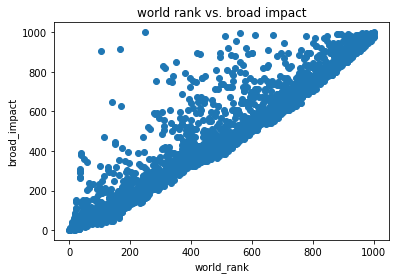

In [10]:
#check missing values in cwur data
print('CWUR values')
print(cwur.isnull().sum())

#First glance at the data suggests, that the missing value column broad impact seems to correlate with world rank
#(imputation likely choice):
plt.scatter(cwur['world_rank'], cwur['broad_impact'])
plt.title('world rank vs. broad impact')
plt.xlabel('world_rank')
plt.ylabel('broad_impact')

#Use Encoder to encode categories (country, institution)
encInst = sk.preprocessing.LabelEncoder().fit(cwur['university_name'])
encCon = sk.preprocessing.LabelEncoder().fit(cwur['country'])

cwur['university_name']  = encInst.transform(cwur['university_name'])
cwur['country'] =  encCon.transform(cwur['country'])

#general cutoff for imputation without introducing bias is 3% of rows contained with missing values -> 
#use multivariate imputation
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(cwur)

cwur_imputed = pd.DataFrame(imp.transform(cwur), columns = cwur.columns)

#keep a copy of encoded labels for purposes
cwur_imputed_enc = cwur_imputed.copy()

#we transform back our label encoding back after imputation
cwur_imputed['country'] = encCon.inverse_transform(cwur['country'])
cwur_imputed['university_name'] = encInst.inverse_transform(cwur['university_name'])
cwur['country'] = encCon.inverse_transform(cwur['country'])
cwur['university_name'] = encInst.inverse_transform(cwur['university_name'])

#### 2.6.2 Drop Shanghai missing data and drop unneeded column

The total score for countries with lower scores is missing. Due this specific characteristic (total_score) being contained in CWUR dataset already, it was decided to completely remove this column. Other columns contained a miniscule amount of missing data, those rows are to be removed.

In [11]:
print('-----------------------')
#check missing values in shanghai data
print('SHANGHAI values')
print(shanghai.isnull().sum())

shanghai.drop(('total_score'), axis = 1, inplace=True)
shanghai.dropna(inplace=True)
shanghai.shape

-----------------------
SHANGHAI values
world_rank            0
university_name       0
national_rank         0
total_score        3795
alumni                0
                   ... 
hici                  1
ns                   21
pub                   1
pcp                   1
year                  0
Length: 11, dtype: int64


(4875, 10)

#### 2.6.3 Drop HDI missing data
This dataset is relatively complete with the exception of four undocumented rows of hdi scores, which should be removed.

In [12]:
print('-----------------------')
#check missing values in hdi
print('HDI values')
print(hdi_ref.isnull().sum())

hdi_ref.dropna(inplace=True)
shanghai.shape

-----------------------
HDI values
year        0
country     0
hdi_rank    0
hdi         4
dtype: int64


(4875, 10)

#### 2.6.4 Impute CPI data

Due to this dataset having less values but also relatively less missing data, it was decided that the missing data shall be imputed.

In [13]:
print('-----------------------')
#check missing values in corruption data
print('CPI values')
print(corruption_ref.isnull().sum())

#check row num
print(corruption_ref.shape)

#Use Encoder to encode categories (country, institution)
encCon = sk.preprocessing.LabelEncoder().fit(corruption_ref['country'])

corruption_ref['country'] =  encCon.transform(corruption_ref['country'])

#general cutoff for imputation without introducing bias is 3% of rows contained with missing values -> 
#use multivariate imputation
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(corruption_ref)

corruption_imputed = pd.DataFrame(imp.transform(corruption_ref), columns = corruption_ref.columns)


#we transform back our label encoding back after imputation
corruption_imputed['country'] = encCon.inverse_transform(corruption_ref['country'])
corruption_imputed.shape

-----------------------
CPI values
cpi_rank      0
country       0
year          0
cpi_score    21
dtype: int64
(880, 4)


(880, 4)

#### 2.6.5 Drop Expenditure missing data

This dataset contains only three columns but significant missing data. After analysing the dataset, it is evident that whole rows are missing. Imputation in this case is difficult. Removing missing seems to be the only option. The missing data is distributed over years.

In [14]:
print('-----------------------')
#check missing values in expenditure data
print('Expenditure values')
print(educ_expenditure_processed.isnull().sum())
print(educ_expenditure_processed.shape)

#check all rows with at least one missing value
temp = educ_expenditure_processed[educ_expenditure_processed.isna().any(axis=1)]
print(temp.loc[1995].shape)
print(temp.loc[2000].shape)
print(temp.loc[2005].shape)
print(temp.loc[2009].shape)
print(temp.loc[2010].shape)
print(temp.loc[2011].shape)

#remove nan rows
educ_expenditure_processed.dropna(inplace=True)

print(educ_expenditure_processed.shape)

-----------------------
Expenditure values
percentage of GDP  All Institutions (public)                         22
                   Higher Education Institutions (public)            23
                   Elementary and Secondary Institutions (public)    18
dtype: int64
(222, 3)
(6, 3)
(4, 3)
(2, 3)
(3, 3)
(4, 3)
(4, 3)
(199, 3)


In [15]:
print('-----------------------')
#check missing values in number of universities data
print('Number of universities values')
print(nbupc.isnull().sum())

-----------------------
Number of universities values
country                   0
number of universities    0
dtype: int64


In [16]:
print('-----------------------')
#check missing values in number of inhabitants data
print('Number of universities values')
print(inh.isnull().sum())

display(inh[inh["inhabitants"].isnull()])
# it seems that we can safely remove those rows

inh.dropna(inplace=True)

-----------------------
Number of universities values
country        0
inhabitants    2
dtype: int64


,country,inhabitants
67,Eritrea,NaN
108,Not classified,NaN


### 2.7 Merge
Now that data has been cleaned and named correctly, it can be merged flawlessly.

In [17]:
# merge expenditure to cwur data
cwur_exp=educ_expenditure_processed.merge(cwur_imputed, on = ["country"]).copy()
display(cwur_exp)

C:\Users\gabib\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,country,"(percentage of GDP, All Institutions (public))","(percentage of GDP, Higher Education Institutions (public))","(percentage of GDP, Elementary and Secondary Institutions (public))",world_rank,university_name,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
0,Australia,4.5,1.2,3.2,92.0,University of Queensland,1.0,101.0,101.0,101.0,67.0,90.0,89.0,143.125172,46.0,44.18,2012.0
1,Australia,4.5,1.2,3.2,94.0,University of Sydney,2.0,101.0,101.0,101.0,56.0,92.0,85.0,140.092437,69.0,44.13,2012.0
2,Australia,4.5,1.2,3.2,92.0,University of Sydney,1.0,101.0,101.0,101.0,61.0,101.0,101.0,145.129473,48.0,44.77,2013.0
3,Australia,4.5,1.2,3.2,96.0,Australian National University,2.0,101.0,101.0,43.0,101.0,101.0,101.0,156.521104,101.0,44.50,2013.0
4,Australia,4.5,1.2,3.2,95.0,University of Sydney,1.0,127.0,158.0,162.0,50.0,117.0,61.0,94.000000,100.0,51.58,2014.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10676,Brazil,5.9,0.9,4.4,941.0,Federal University of São Carlos,14.0,367.0,567.0,218.0,722.0,948.0,812.0,906.000000,774.0,44.09,2015.0
10677,Brazil,5.9,0.9,4.4,961.0,Federal University of ABC,15.0,367.0,567.0,218.0,929.0,923.0,645.0,921.000000,871.0,44.07,2015.0
10678,Brazil,5.9,0.9,4.4,974.0,Federal University of Santa Maria,16.0,367.0,396.0,218.0,954.0,974.0,812.0,975.000000,871.0,44.05,2015.0
10679,Brazil,5.9,0.9,4.4,992.0,Federal University of Bahia,17.0,367.0,540.0,218.0,962.0,865.0,645.0,969.000000,774.0,44.03,2015.0


We combine the data about the inhabitants with the number of universities. Also, we calculate the number of universities per inhabitant for each country (this value is multiplied by 10 000 000 to get a nice number). Moreover, these values are merged to the CWUR dataset.

In [18]:
inh = inh.merge(nbupc, on = ["country"])

cwur_inh=inh.merge(cwur_imputed, on = ["country"]).copy()
cwur_inh["universities per inhabitant"] = 10**7 *cwur_inh["number of universities"] / cwur_inh["inhabitants"]
display(cwur_inh)

cwur_exp=cwur_exp.merge(inh, on = "country")

,country,inhabitants,number of universities,world_rank,university_name,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year,universities per inhabitant
0,United Arab Emirates,9630959.0,63,924.0,United Arab Emirates University,1.0,355.0,478.0,210.0,983.0,821.0,800.0,897.0,426.0,44.36,2014.0,65.414047
1,United Arab Emirates,9630959.0,63,950.0,United Arab Emirates University,1.0,367.0,521.0,218.0,994.0,851.0,812.0,906.0,689.0,44.08,2015.0,65.414047
2,Argentina,44494502.0,116,378.0,University of Buenos Aires,1.0,192.0,477.0,176.0,268.0,348.0,363.0,349.0,737.0,45.66,2014.0,26.070637
3,Argentina,44494502.0,116,741.0,National University of La Plata,2.0,355.0,476.0,210.0,546.0,523.0,406.0,703.0,737.0,44.59,2014.0,26.070637
4,Argentina,44494502.0,116,897.0,National University of Córdoba,3.0,355.0,478.0,210.0,713.0,818.0,609.0,849.0,737.0,44.39,2014.0,26.070637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2041,South Africa,57779622.0,120,149.0,University of the Witwatersrand,1.0,61.0,32.0,172.0,442.0,237.0,321.0,447.0,291.0,48.75,2015.0,20.768568
2042,South Africa,57779622.0,120,248.0,University of Cape Town,2.0,104.0,126.0,146.0,319.0,236.0,234.0,265.0,268.0,46.58,2015.0,20.768568
2043,South Africa,57779622.0,120,306.0,Stellenbosch University,3.0,367.0,66.0,218.0,520.0,503.0,321.0,486.0,219.0,45.92,2015.0,20.768568
2044,South Africa,57779622.0,120,478.0,University of KwaZulu-Natal,4.0,367.0,148.0,218.0,562.0,397.0,368.0,579.0,539.0,44.85,2015.0,20.768568


In the next cell, we merge Shanghai data with additional university information datset.

In [19]:
shanghai = pd.merge(shanghai, uni2country, how='left', on='university_name')
shanghai['country'] = shanghai['country'].fillna('unknown')

Here we merge CWUR data with the dataset consisting of countries by region, so we can analyse rankings by region

In [20]:
cwur_countr_reg = pd.merge(cwur_imputed, countr_reg, left_on=['country'], right_on = ['country'])

CPI data is merged with CWUR data for analysis of corruption and rankings by region

In [21]:
cwur_cpi_reg = pd.merge(corruption_imputed, cwur_countr_reg, left_on=['year', 'country'], right_on = ['year','country'])

HDI data is merged with CWUR data in the following cell

In [22]:
cwur_hdi = pd.merge(cwur_imputed, hdi_ref, left_on=['year','country'], right_on = ['year','country'])

## Step 3: Explore the data

### 3.1 Comparing the different rankings of two universities

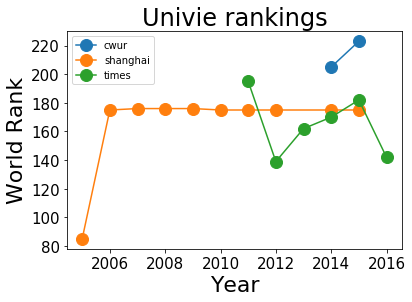

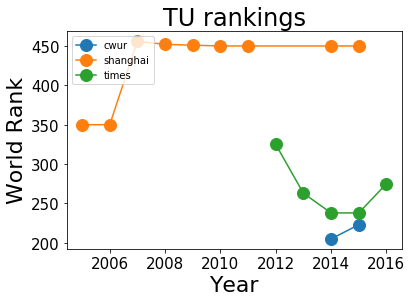

In [23]:
cwur_univie = cwur[cwur.university_name.isin(["University of Vienna"])][['world_rank', 'year']]
cwur_univie['survey'] = "cwur"
times_univie = times[times.university_name.isin(["University of Vienna"])][['world_rank', 'year']]
times_univie['survey'] = "times"
shanghai_univie = shanghai[shanghai.university_name.isin(["University of Vienna"])][['world_rank', 'year']]
shanghai_univie['survey'] = "shanghai"
all_surveys_univie = cwur_univie.append(times_univie).append(shanghai_univie)

cwur_TU = cwur[cwur.university_name.isin(["Vienna University of Technology"])][['world_rank', 'year']]
cwur_TU['survey'] = "cwur"
times_TU = times[times.university_name.isin(["Vienna University of Technology"])][['world_rank', 'year']]
times_TU['survey'] = "times"
shanghai_TU = shanghai[shanghai.university_name.isin(["Vienna University of Technology"])][['world_rank', 'year']]
shanghai_TU['survey'] = "shanghai"
all_surveys_TU = cwur_univie.append(times_TU).append(shanghai_TU)

groups_univie = all_surveys_univie.groupby('survey')

fig, ax = plt.subplots()
ax.margins(0.05)

for name, group in groups_univie:
    ax.plot(group.year, group.world_rank, marker='o', linestyle='-', ms=12, label=name)
    
ax.legend(loc=2,prop={'size':10})

plt.title("Univie rankings", fontsize=24)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)    
plt.ylabel("World Rank", fontsize=22)  
plt.xlabel("Year", fontsize=22)
plt.show()

groups_TU = all_surveys_TU.groupby('survey')

fig, ax = plt.subplots()
ax.margins(0.05)

for name, group in groups_TU:
    ax.plot(group.year, group.world_rank, marker='o', linestyle='-', ms=12, label=name)
    
ax.legend(loc=2,prop={'size':10})

plt.title("TU rankings", fontsize=24)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)    
plt.ylabel("World Rank", fontsize=22)  
plt.xlabel("Year", fontsize=22)
plt.show()

### 3.2 Overview over the CWUR dataset

The main goal here is to get an overview over the CWUR dataset. In particular, we are interested in the relationship between the different features and whether they correlate or not. For this we plot a heatmap of the correlation matrix as well as scatterplots of each variable combined with the world rank

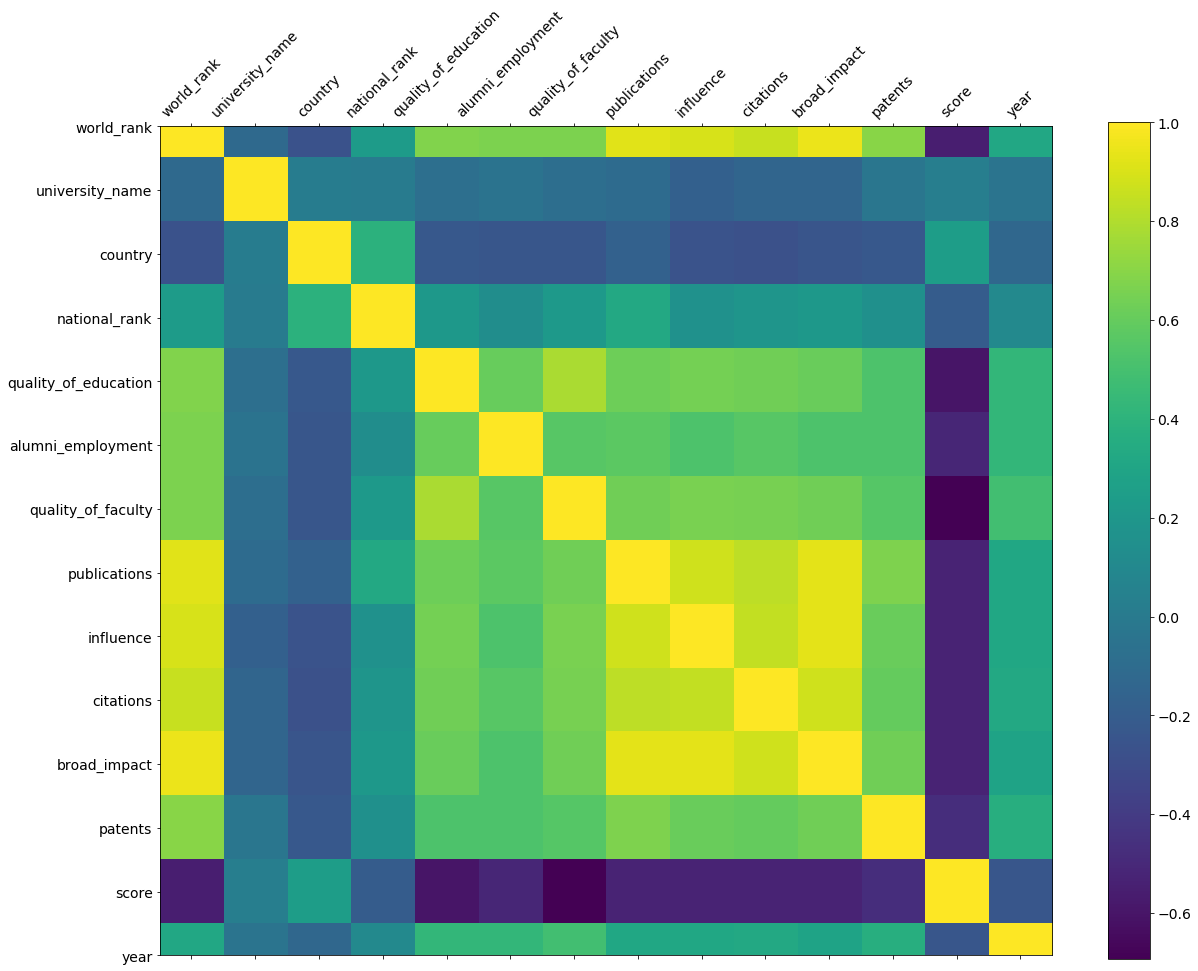

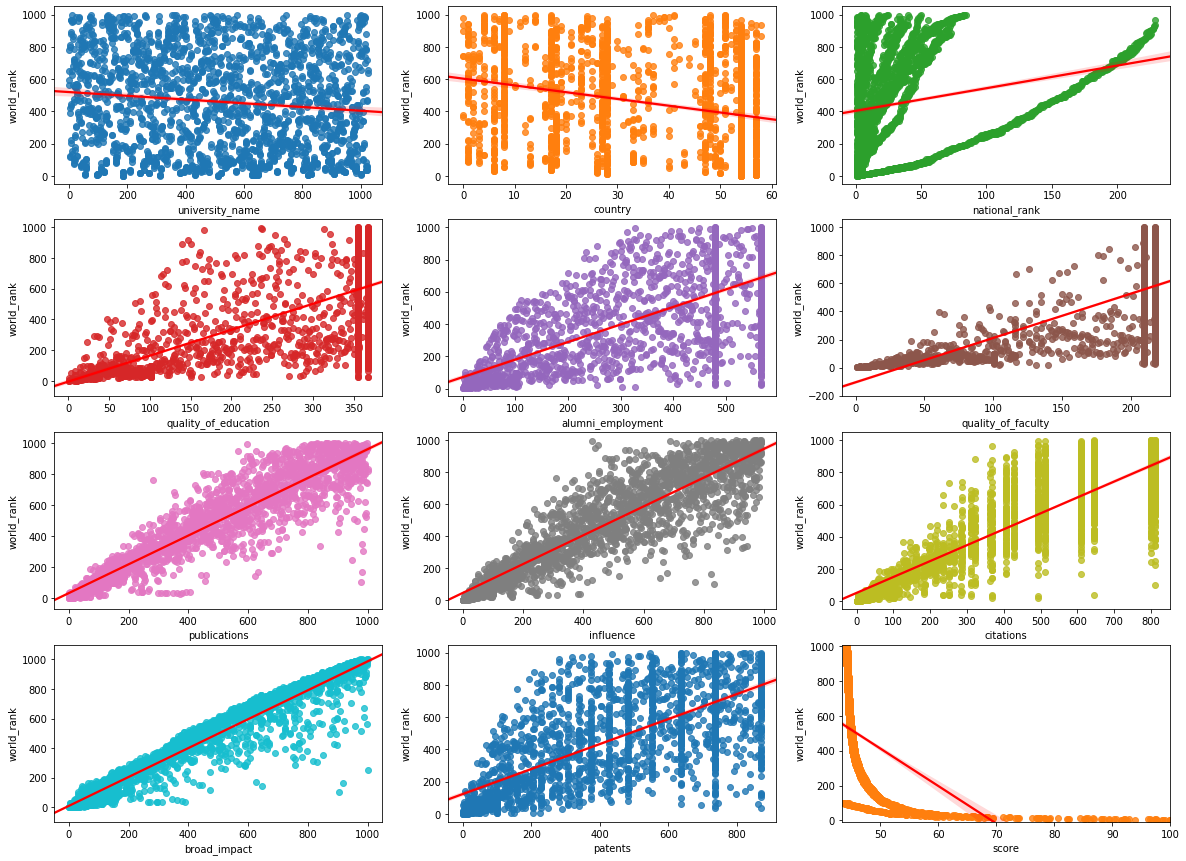

In [24]:
#Visualize Data

#Heatmap
fig1 = plt.figure(figsize=(20, 15))
plt.matshow(cwur_imputed_enc.corr(), fignum=fig1.number)
plt.xticks(range(cwur_imputed_enc.shape[1]), cwur_imputed_enc.columns, fontsize=14, rotation=45)
plt.yticks(range(cwur_imputed_enc.shape[1]), cwur_imputed_enc.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

#scatterplots vs. world rank

fig2, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))

sb.regplot(y='world_rank', x='university_name', data=cwur_imputed_enc,  line_kws = {'color':'red'}, ax=axs[0,0])
sb.regplot(y='world_rank', x='country', data=cwur_imputed_enc,  line_kws = {'color':'red'}, ax=axs[0,1])
sb.regplot(y='world_rank', x='national_rank', data=cwur_imputed_enc,  line_kws = {'color':'red'}, ax=axs[0,2])

sb.regplot(y='world_rank', x='quality_of_education', data=cwur_imputed_enc,  line_kws = {'color':'red'}, ax=axs[1,0])
sb.regplot(y='world_rank', x='alumni_employment', data=cwur_imputed_enc,  line_kws = {'color':'red'}, ax=axs[1,1])
sb.regplot(y='world_rank', x='quality_of_faculty', data=cwur_imputed_enc,  line_kws = {'color':'red'}, ax=axs[1,2])

sb.regplot(y='world_rank', x='publications', data=cwur_imputed_enc,  line_kws = {'color':'red'}, ax=axs[2,0])
sb.regplot(y='world_rank', x='influence', data=cwur_imputed_enc,  line_kws = {'color':'red'}, ax=axs[2,1])
sb.regplot(y='world_rank', x='citations', data=cwur_imputed_enc,  line_kws = {'color':'red'}, ax=axs[2,2])

sb.regplot(y='world_rank', x='broad_impact', data=cwur_imputed_enc,  line_kws = {'color':'red'}, ax=axs[3,0])
sb.regplot(y='world_rank', x='patents', data=cwur_imputed_enc,  line_kws = {'color':'red'}, ax=axs[3,1])
sb.regplot(y='world_rank', x='score', data=cwur_imputed_enc,  line_kws = {'color':'red'}, ax=axs[3,2])
axs[3,2].set(xlim=(cwur_imputed_enc['score'].min(), cwur_imputed_enc['score'].max()))
axs[3,2].set(ylim=(cwur_imputed_enc['world_rank'].min()-10, cwur_imputed_enc['world_rank'].max()+10))

fig1.savefig('graphs/world_uni_hm.png', bbox_inches = 'tight')
fig1.savefig('graphs/rank_scatterplot.png', bbox_inches = 'tight')


### 3.3 Analyzing changes in rankings

Also, we would like to investigate how the changes (i.e. differences) in the rankings are behaving and how they are related to changes of other features. For this we plot the boxplot of the rank differences and the heatmap of the correlation matrix of the differences.

count    1176.00000
mean        2.45068
std        40.63181
min      -338.00000
25%       -15.00000
50%         0.00000
75%        16.00000
max       324.00000
Name: world_rank, dtype: float64


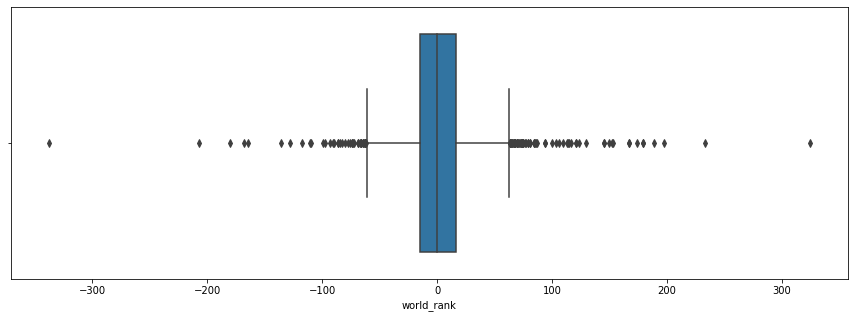

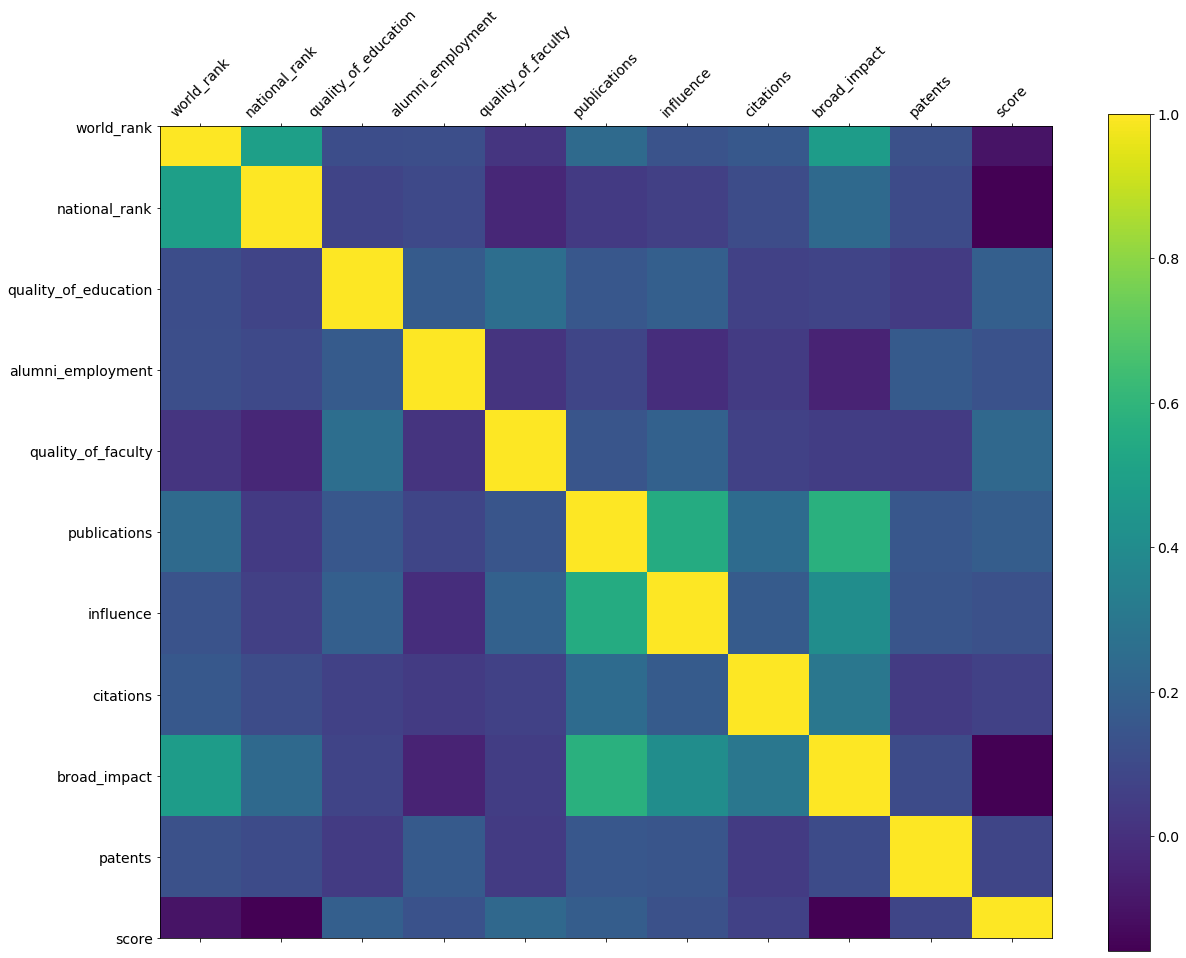

In [25]:
cwur_indexed = cwur_imputed.set_index(['year', 'university_name'])


cwur_diff = cwur_indexed.groupby(by='university_name').diff()


fig1 = plt.figure(figsize=(15, 5))
ax = sb.boxplot(x=cwur_diff['world_rank'])

#Heatmap
fig1 = plt.figure(figsize=(20, 15))
plt.matshow(cwur_diff.corr(), fignum=fig1.number)
plt.xticks(range(cwur_diff.shape[1]), cwur_diff.columns, fontsize=14, rotation=45)
plt.yticks(range(cwur_diff.shape[1]), cwur_diff.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)



print(cwur_diff['world_rank'].describe())

### 3.3 University rank and regional properties

In this part of the work, we would like to find out how regional properties of the universities' locations affect their rankings. The regional properties we analyzed include the countries' HDI (Human Development Index), the expenditures for public educational institutions (especially for higher education) in relation to the countries' GDP and also the abolute and relative (per capita) number of universities.

#### 3.3.1 TODO

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

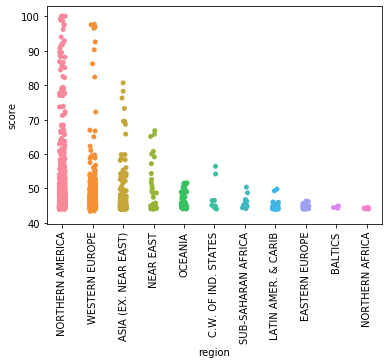

In [26]:
sb.stripplot(x="region", y="score", data=cwur_countr_reg, jitter=True)
plt.xticks(rotation=90)

#### 3.3.2 HDI

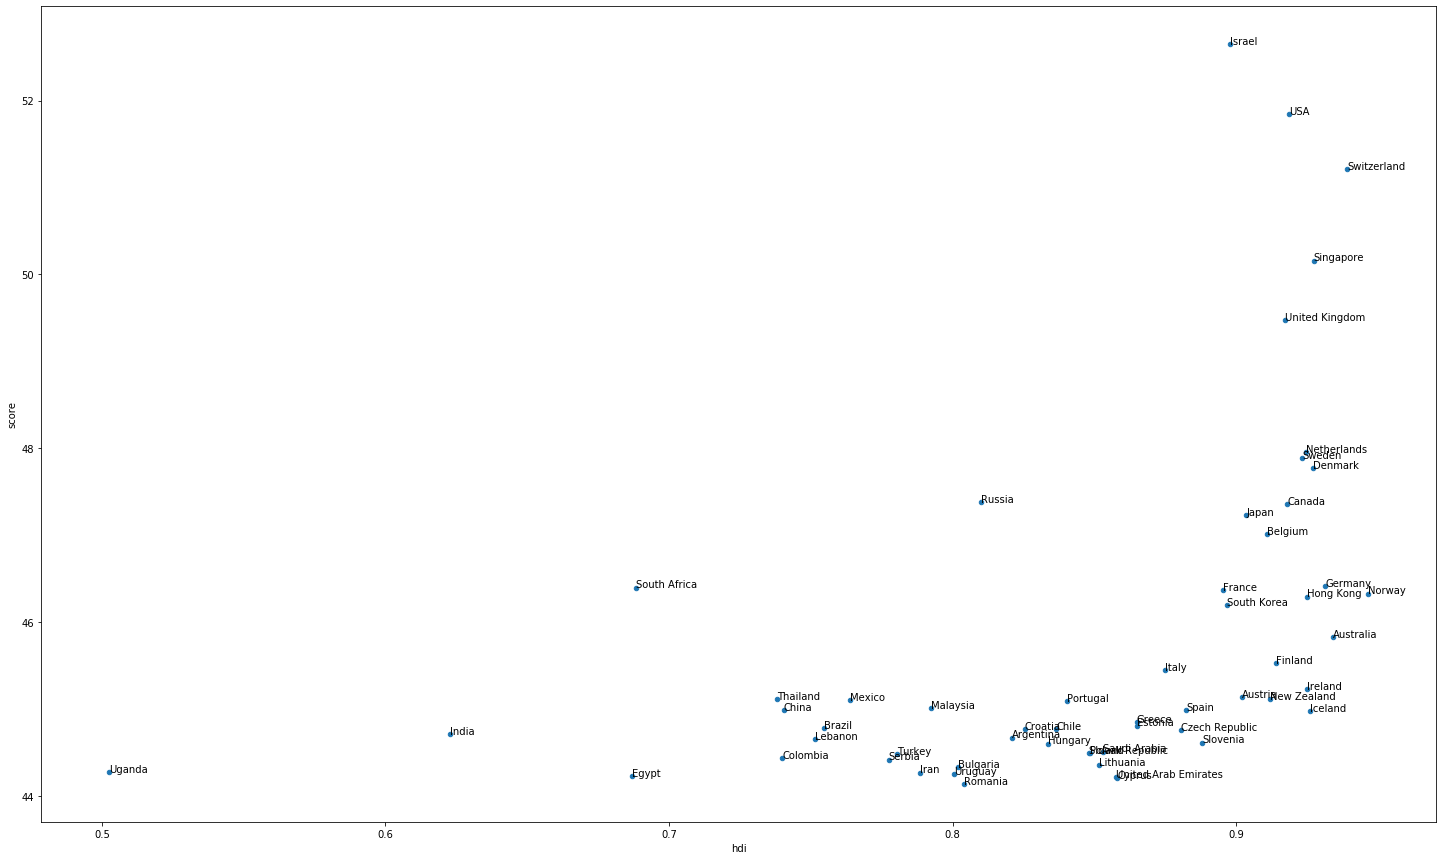

In [27]:
#check how HDI of countries correlates with rankings

#calculate mean world rank

cwur_hdi_mean = cwur_hdi.groupby("country").mean()

fig, ax = plt.subplots()
cwur_hdi_mean.plot("hdi", "score", kind="scatter",
             figsize = (25,15), ax=ax)

for k, v in cwur_hdi_mean.iterrows():
    x = v["hdi"]
    y = v["score"]
    ax.annotate(k, (x,y))
      
plt.show()


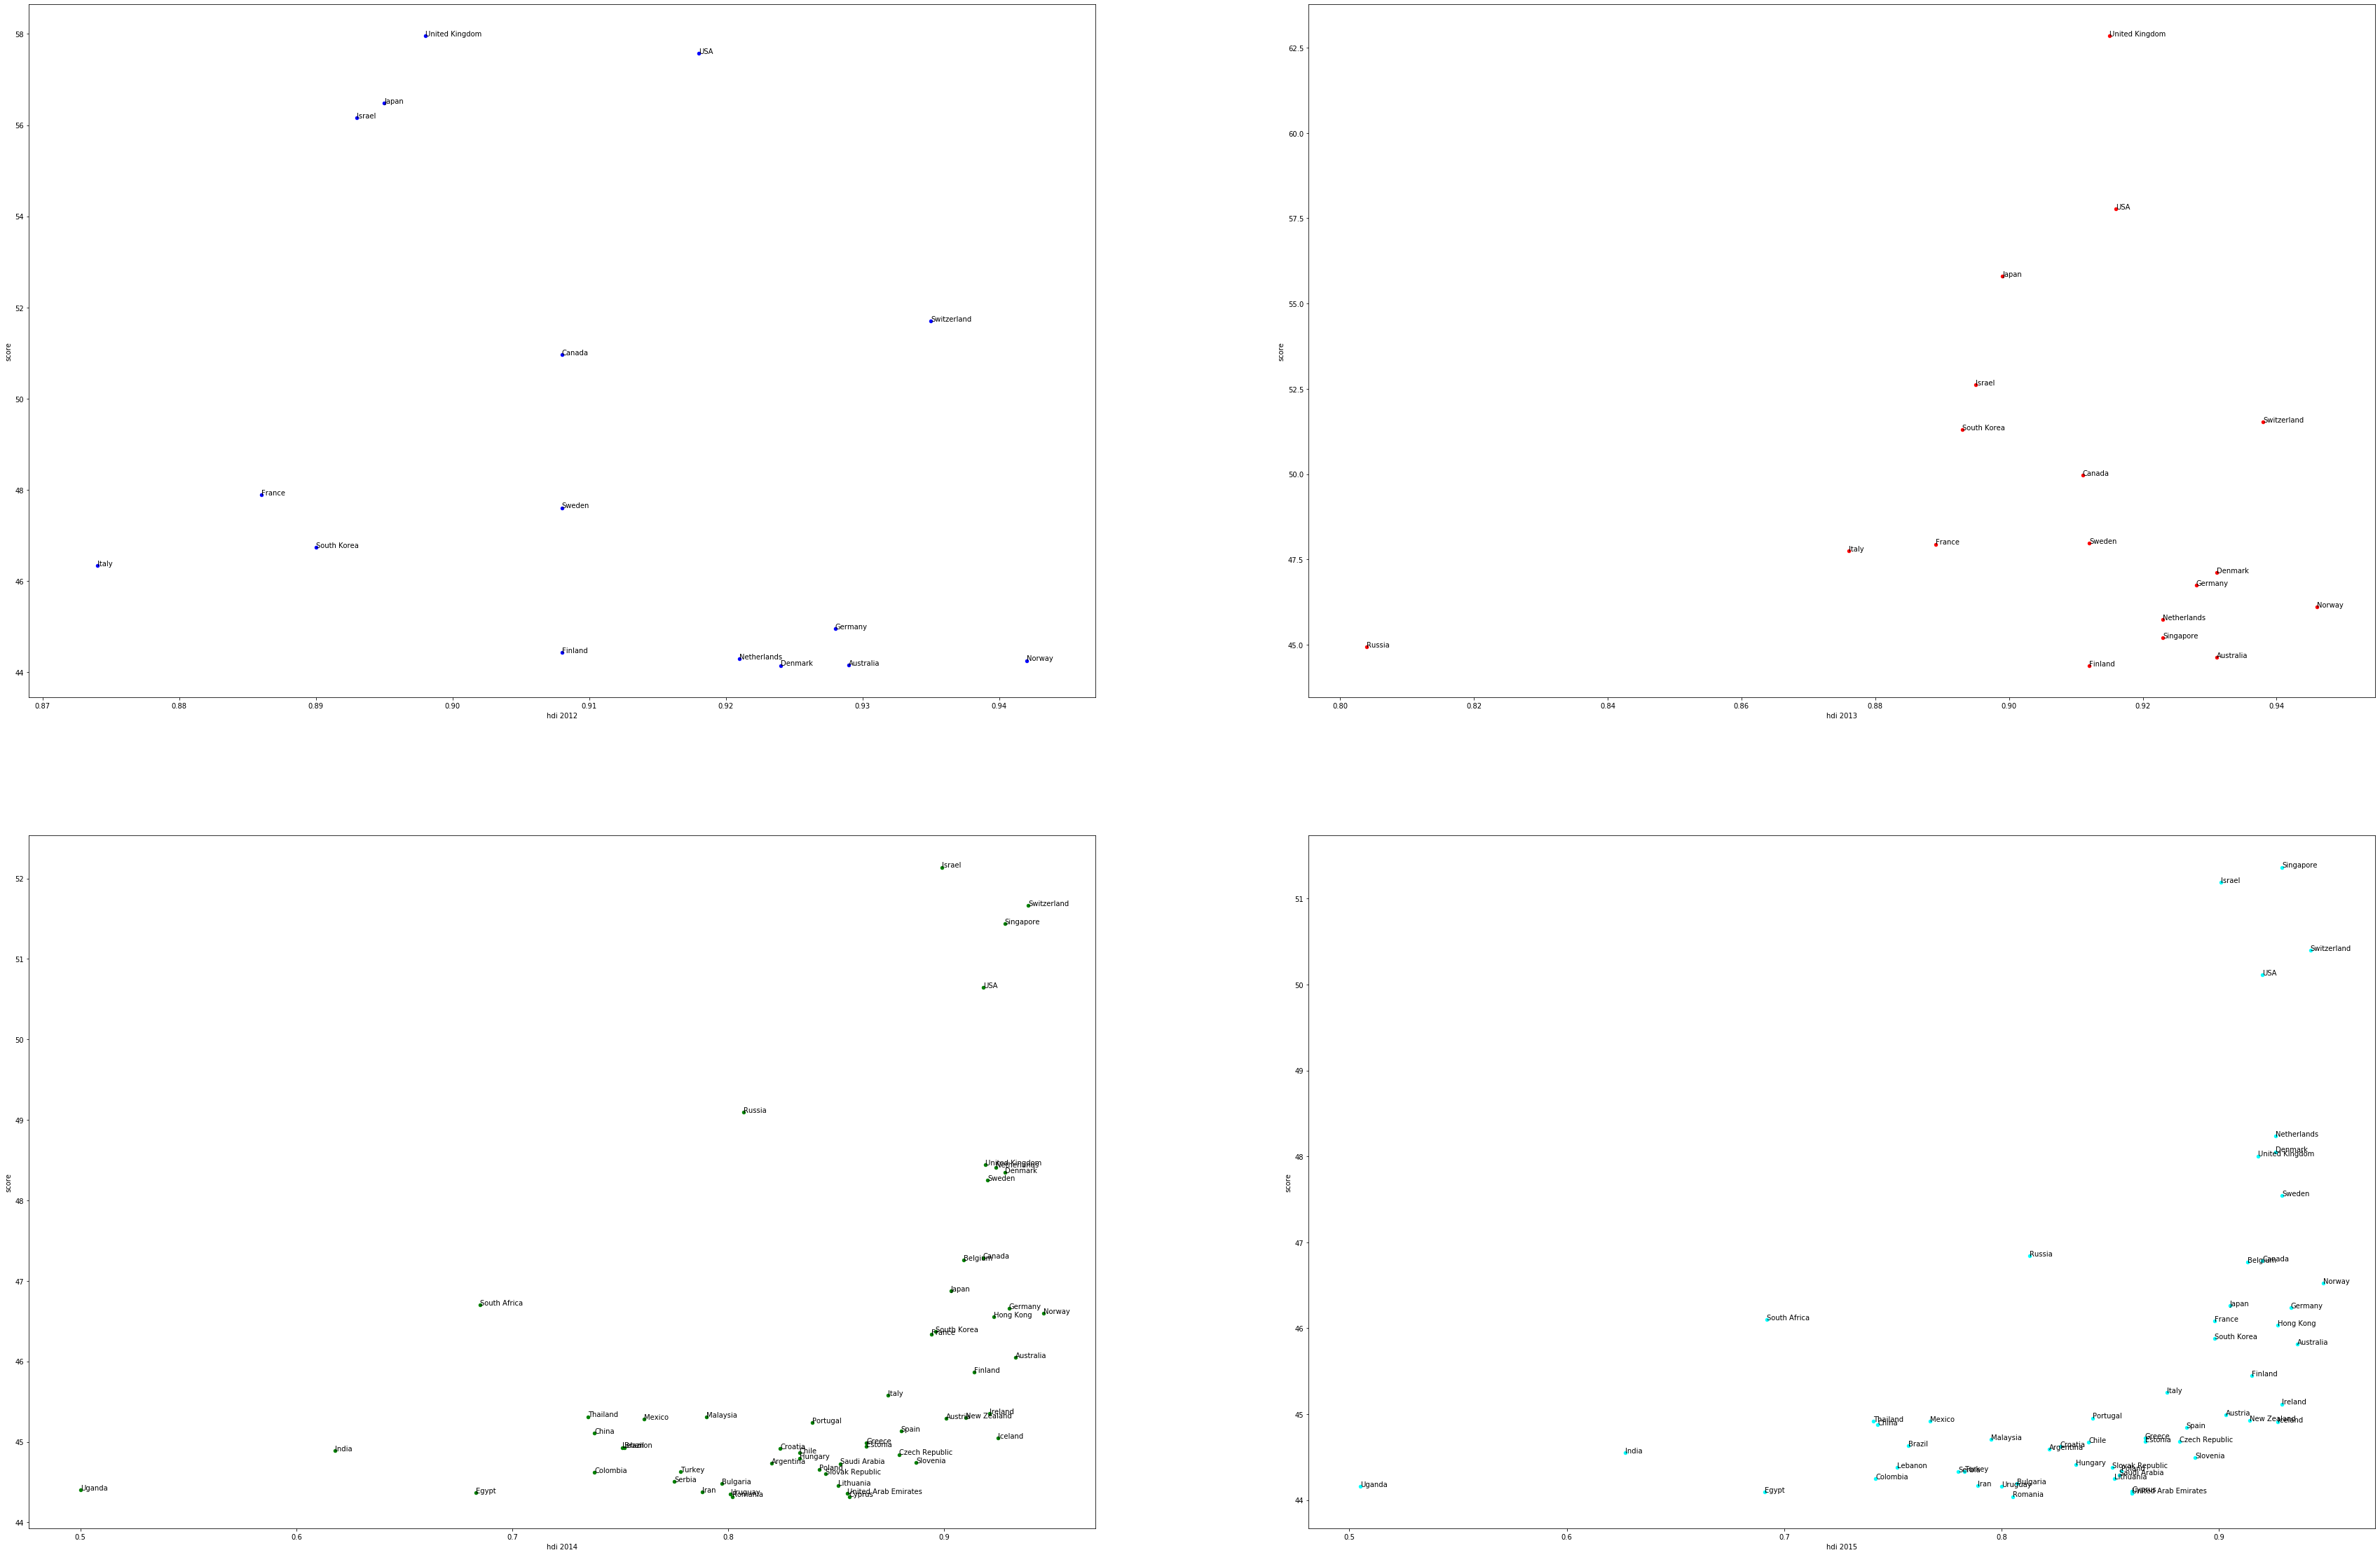

In [28]:
#check how HDI of countries correlates with rankings

#calculate mean world rank

cwur_hdi_mean = cwur_hdi.groupby(["year", "country"]).mean()
cwur_hdi_mean12 = cwur_hdi_mean.iloc[cwur_hdi_mean.index.get_level_values('year') == 2012.0]
cwur_hdi_mean13 = cwur_hdi_mean.iloc[cwur_hdi_mean.index.get_level_values('year') == 2013.0]
cwur_hdi_mean14 = cwur_hdi_mean.iloc[cwur_hdi_mean.index.get_level_values('year') == 2014.0]
cwur_hdi_mean15 = cwur_hdi_mean.iloc[cwur_hdi_mean.index.get_level_values('year') == 2015.0]

fig, axs = plt.subplots(nrows=2, ncols=2)
cwur_hdi_mean12.plot("hdi", "score", kind="scatter",
             figsize = (60,40), ax=axs[0,0], color = "blue")
axs[0,0].set_xlabel("hdi 2012")


for k, v in cwur_hdi_mean12.iterrows():
    x = v["hdi"]
    y = v["score"]
    axs[0,0].annotate(k[1], (x,y))

cwur_hdi_mean13.plot("hdi", "score", kind="scatter",
             figsize = (60,40), ax=axs[0,1], color = "red")
axs[0,1].set_xlabel("hdi 2013")
for k, v in cwur_hdi_mean13.iterrows():
    x = v["hdi"]
    y = v["score"]
    axs[0,1].annotate(k[1], (x,y))

cwur_hdi_mean14.plot("hdi", "score", kind="scatter",
             figsize = (60,40), ax=axs[1,0], color = "green")
axs[1,0].set_xlabel("hdi 2014")
for k, v in cwur_hdi_mean14.iterrows():
    x = v["hdi"]
    y = v["score"]
    axs[1,0].annotate(k[1], (x,y))

cwur_hdi_mean15.plot("hdi", "score", kind="scatter",
             figsize = (60,40), ax=axs[1,1], color = "cyan")
axs[1,1].set_xlabel("hdi 2015")
for k, v in cwur_hdi_mean15.iterrows():
    x = v["hdi"]
    y = v["score"]
    axs[1,1].annotate(k[1], (x,y))
    
    
plt.show()


#### 3.3.3 Public expenditures on education per country

We would like to find out how the expenditures for public education influences the rank of the universities of a country. Unfortuneatly, the data containing the expenditures and the data from the CWUR ranking have different time ranges. Therefore we will only group the data by country and look what effect a country's expenditures have on the mean, maximal and minimal score. This is done for the total expenditure (i.e. for all public institutions) as well as for higher education institutions only.

In [29]:
cwur.set_index(["year", "university_name"], inplace=True)

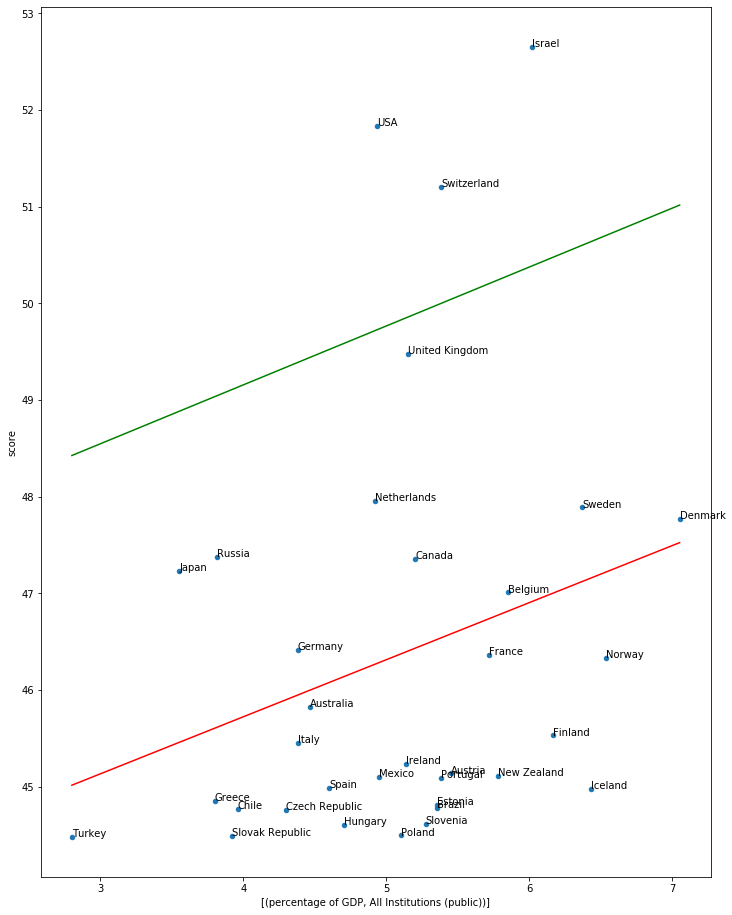

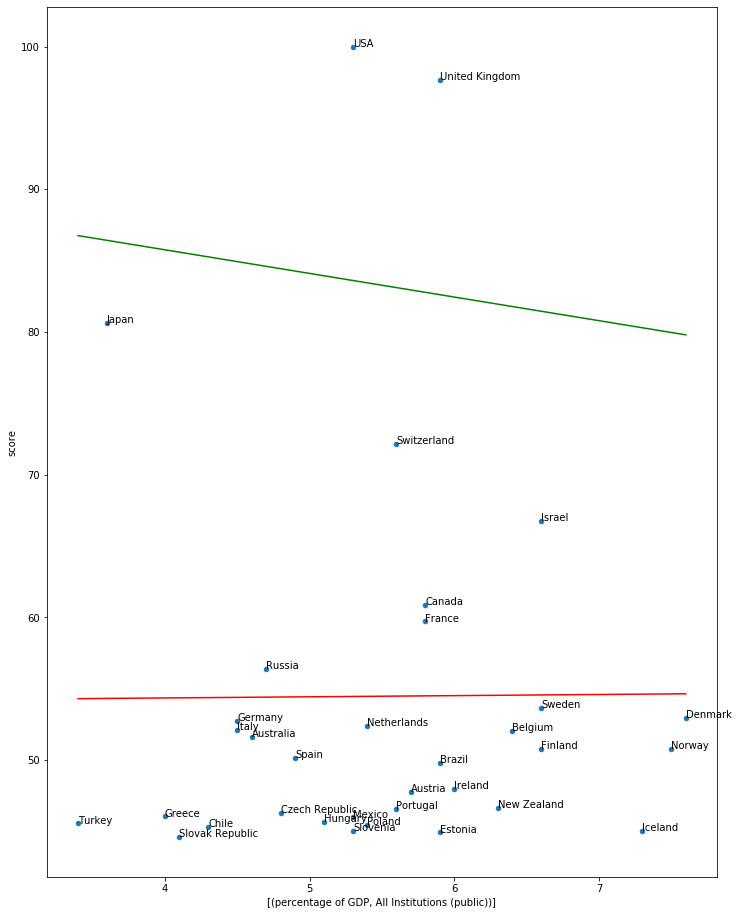

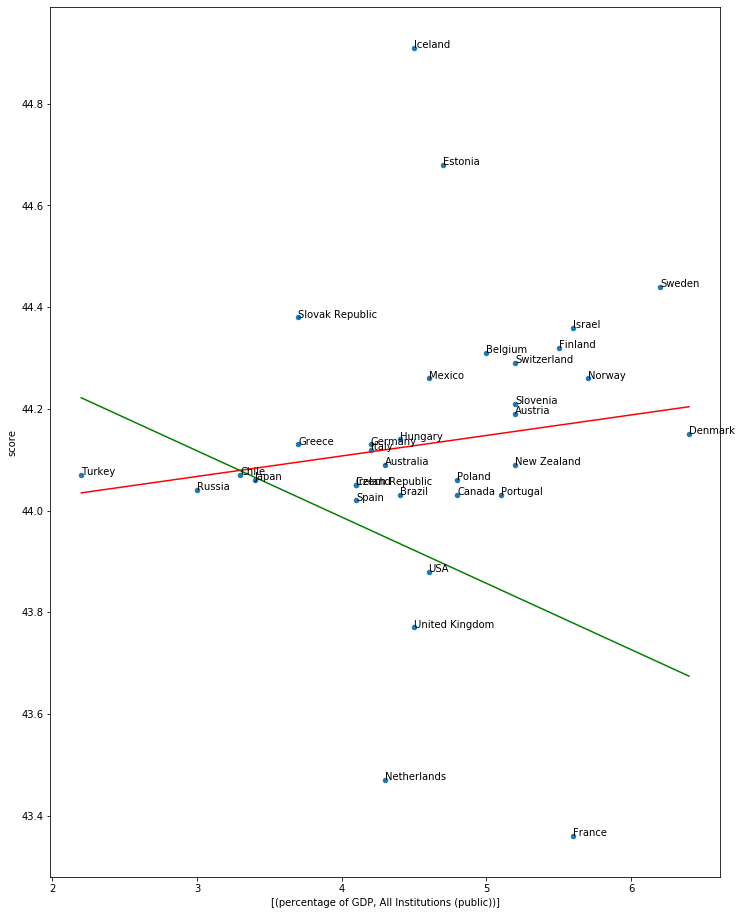

In [30]:
cwur2 = cwur_exp.groupby("country").mean()
cwur3 = cwur_exp.groupby("country").max()
cwur4 = cwur_exp.groupby("country").min()

fig, ax = plt.subplots()

cwur2.plot([('percentage of GDP', 'All Institutions (public)')], "score", kind="scatter",
             figsize = (12,16), ax=ax)
x=cwur2[('percentage of GDP', 'All Institutions (public)')]
y=cwur2["score"]
b, m = polyfit(x,y, 1)
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="red")
b, m = polyfit(x,y, 1, w=cwur2["number of universities"])
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="green")

for k, v in cwur2.iterrows():
    x = v[('percentage of GDP', 'All Institutions (public)')]
    y = v["score"]
    ax.annotate(k, (x,y))
    
plt.show()

fig, ax = plt.subplots()
cwur3.plot([('percentage of GDP', 'All Institutions (public)')], "score", kind="scatter",
             figsize = (12,16), ax=ax)
x=cwur3[('percentage of GDP', 'All Institutions (public)')]
y=cwur3["score"]
b, m = polyfit(x,y, 1)
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="red")
b, m = polyfit(x,y, 1, w=cwur3["number of universities"])
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="green")


for k, v in cwur3.iterrows():
    x = v[('percentage of GDP', 'All Institutions (public)')]
    y = v["score"]
    ax.annotate(k, (x,y))
plt.show()

fig, ax = plt.subplots()
cwur4.plot([('percentage of GDP', 'All Institutions (public)')], "score", kind="scatter",
             figsize = (12,16), ax=ax)
x=cwur4[('percentage of GDP', 'All Institutions (public)')]
y=cwur4["score"]
b, m = polyfit(x,y, 1)
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="red")

b, m = polyfit(x,y, 1, w=cwur4["number of universities"])
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="green")

for k, v in cwur4.iterrows():
    x = v[('percentage of GDP', 'All Institutions (public)')]
    y = v["score"]
    ax.annotate(k, (x,y))
plt.show()

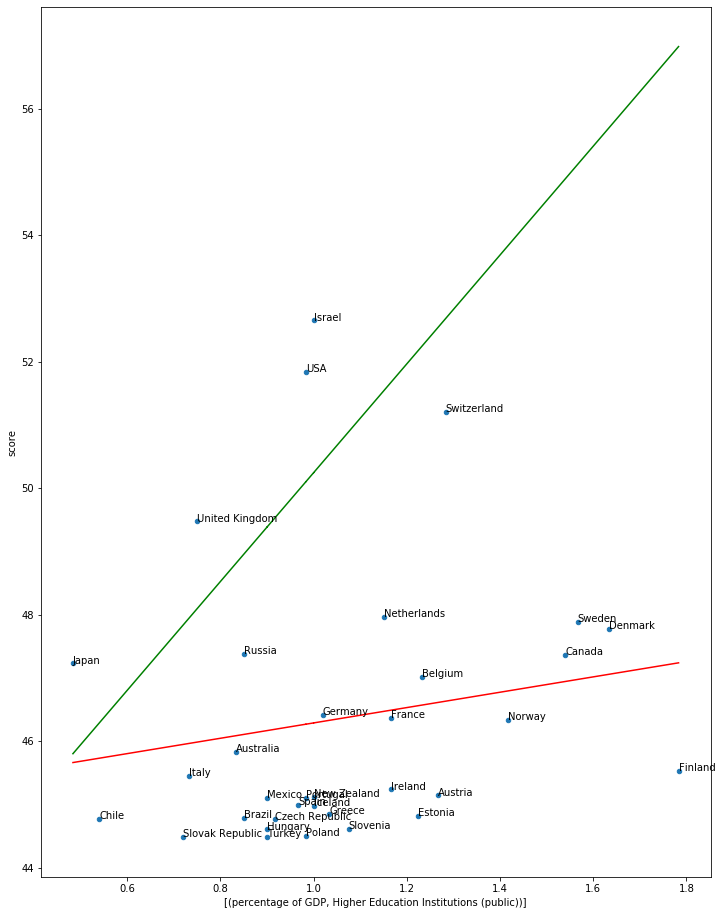

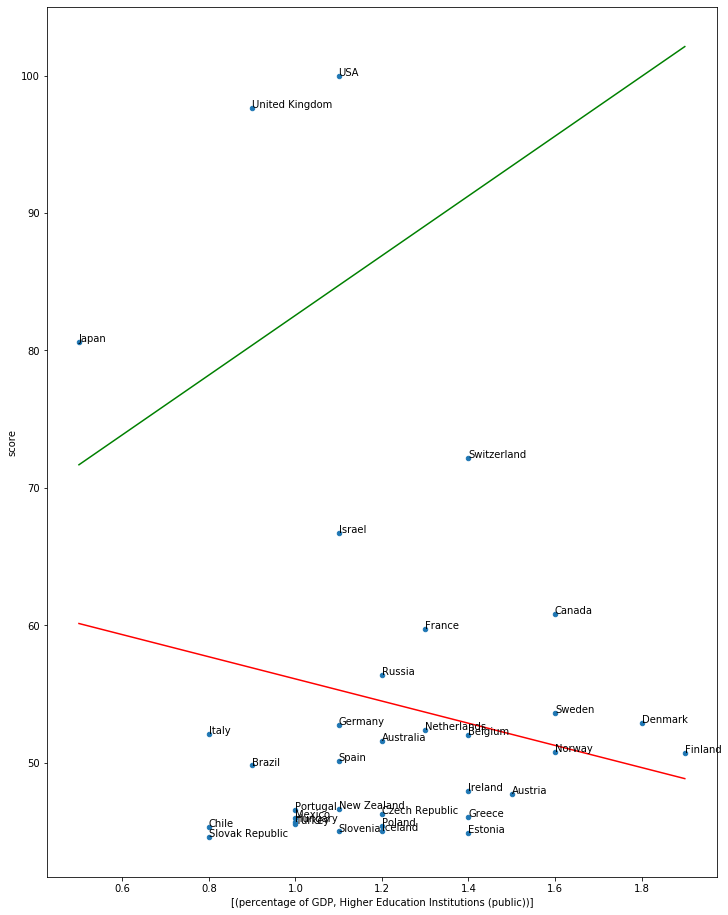

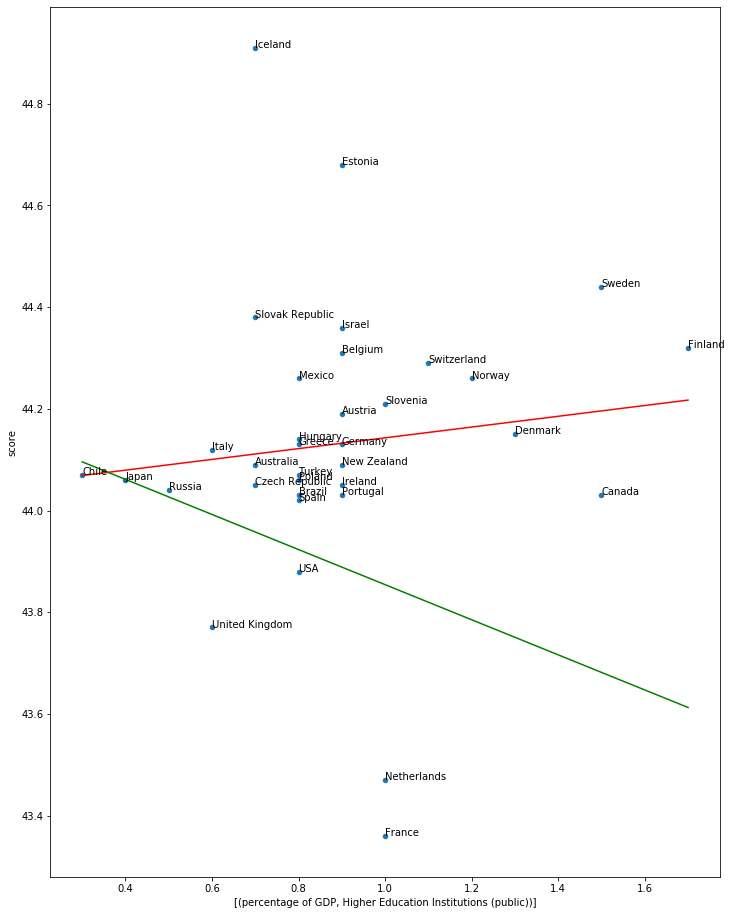

In [31]:
cwur2 = cwur_exp.groupby("country").mean()
fig, ax = plt.subplots()

cwur2.plot([('percentage of GDP', 'Higher Education Institutions (public)')], "score", kind="scatter",
             figsize = (12,16), ax=ax)
x=cwur2[('percentage of GDP', 'Higher Education Institutions (public)')]
y=cwur2["score"]
b, m = polyfit(x,y, 1)
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="red")

b, m = polyfit(x,y, 1, w=cwur2["number of universities"])
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="green")


for k, v in cwur2.iterrows():
    x = v[('percentage of GDP', 'Higher Education Institutions (public)')]
    y = v["score"]
    ax.annotate(k, (x,y))
plt.show()

fig, ax = plt.subplots()
cwur3.plot([('percentage of GDP', 'Higher Education Institutions (public)')], "score", kind="scatter",
             figsize = (12,16), ax=ax)
x=cwur3[('percentage of GDP', 'Higher Education Institutions (public)')]
y=cwur3["score"]
b, m = polyfit(x,y, 1)
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="red")
b, m = polyfit(x,y, 1, w=cwur3["number of universities"])
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="green")

for k, v in cwur3.iterrows():
    x = v[('percentage of GDP', 'Higher Education Institutions (public)')]
    y = v["score"]
    ax.annotate(k, (x,y))
plt.show()

fig, ax = plt.subplots()
cwur4.plot([('percentage of GDP', 'Higher Education Institutions (public)')], "score", kind="scatter",
             figsize = (12,16), ax=ax)
x=cwur4[('percentage of GDP', 'Higher Education Institutions (public)')]
y=cwur4["score"]
b, m = polyfit(x,y, 1)
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="red")
b, m = polyfit(x,y, 1, w=cwur4["number of universities"])
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="green")

for k, v in cwur4.iterrows():
    x = v[('percentage of GDP', 'Higher Education Institutions (public)')]
    y = v["score"]
    ax.annotate(k, (x,y))
plt.show()

We conclude that TODO

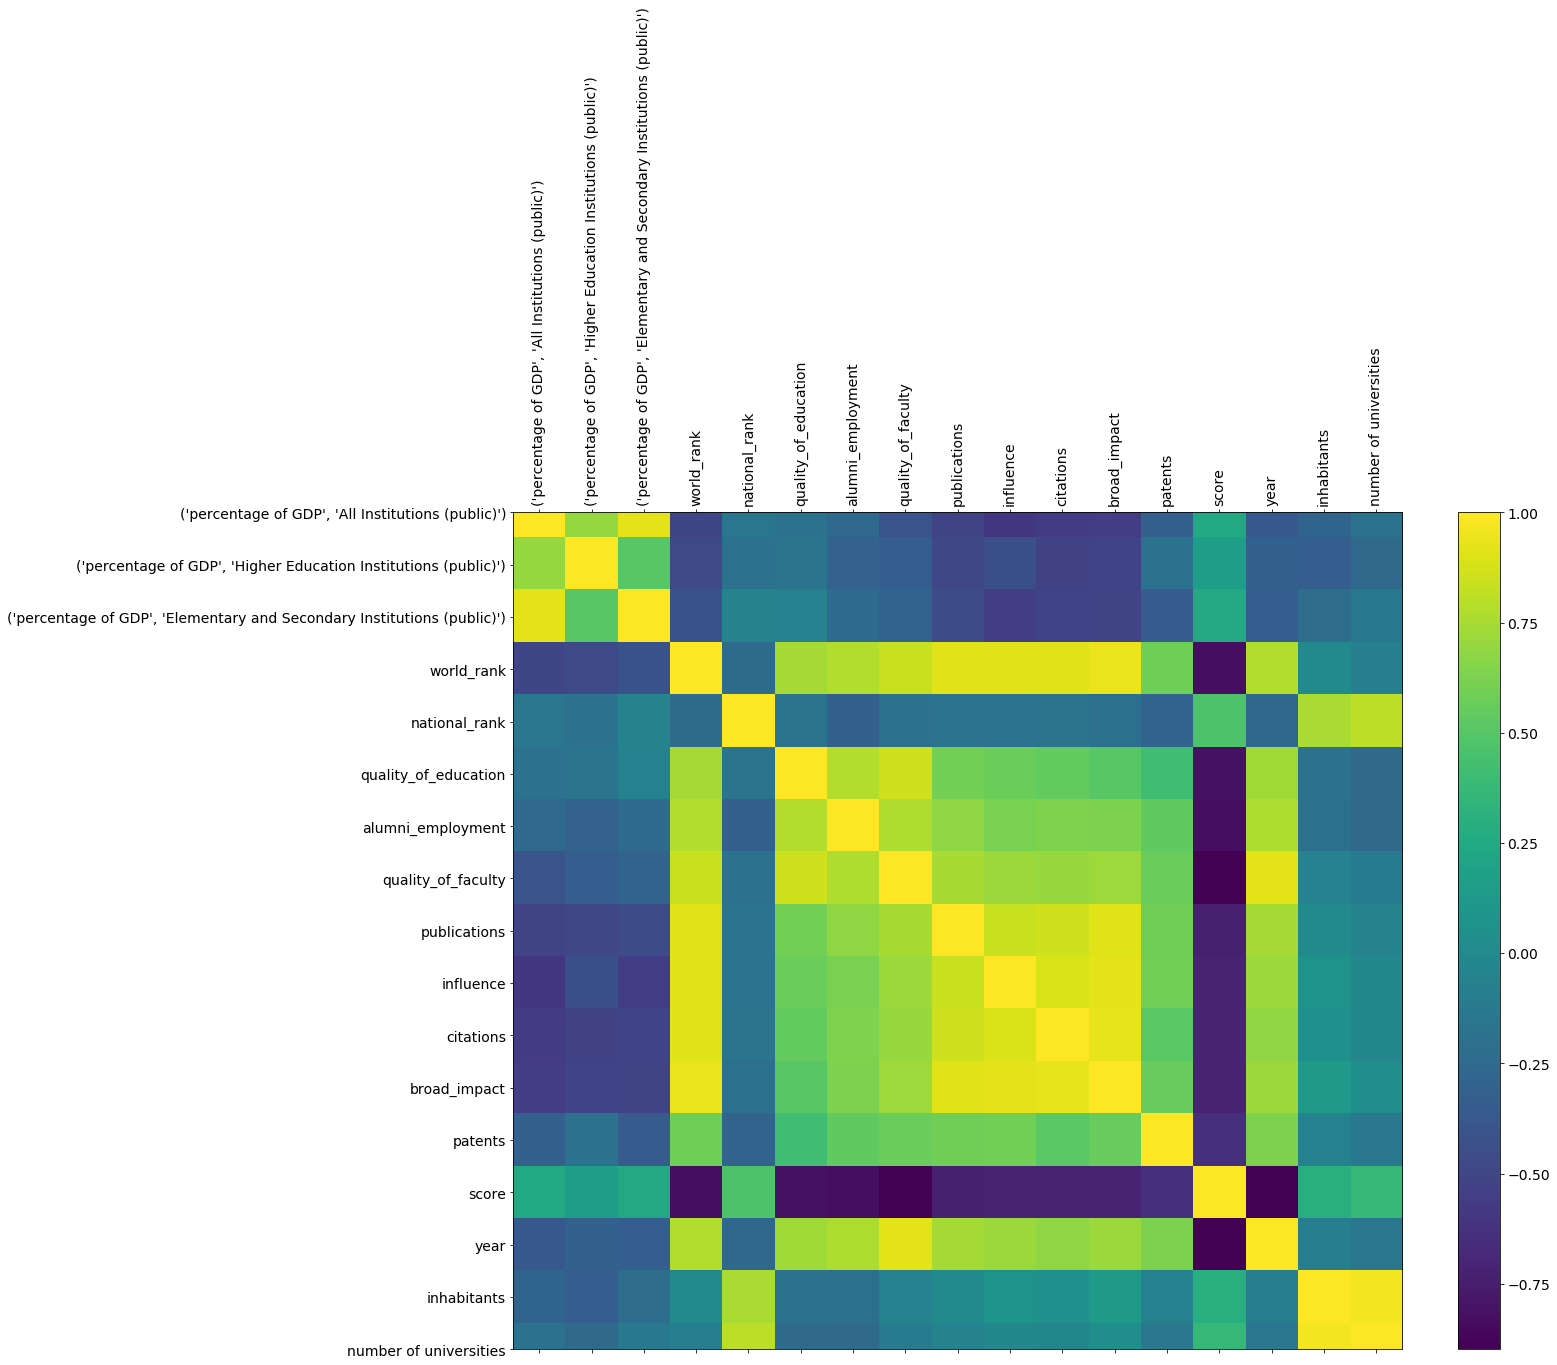

In [32]:
#Heatmap
fig1 = plt.figure(figsize=(20, 15))
plt.matshow(cwur2.corr(), fignum=fig1.number)
plt.xticks(range(cwur2.shape[1]), cwur2.columns, fontsize=14, rotation=90)
plt.yticks(range(cwur2.shape[1]), cwur2.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

#### 3.3.4 Inhabitants, number of universities and number of universities per inhabitant

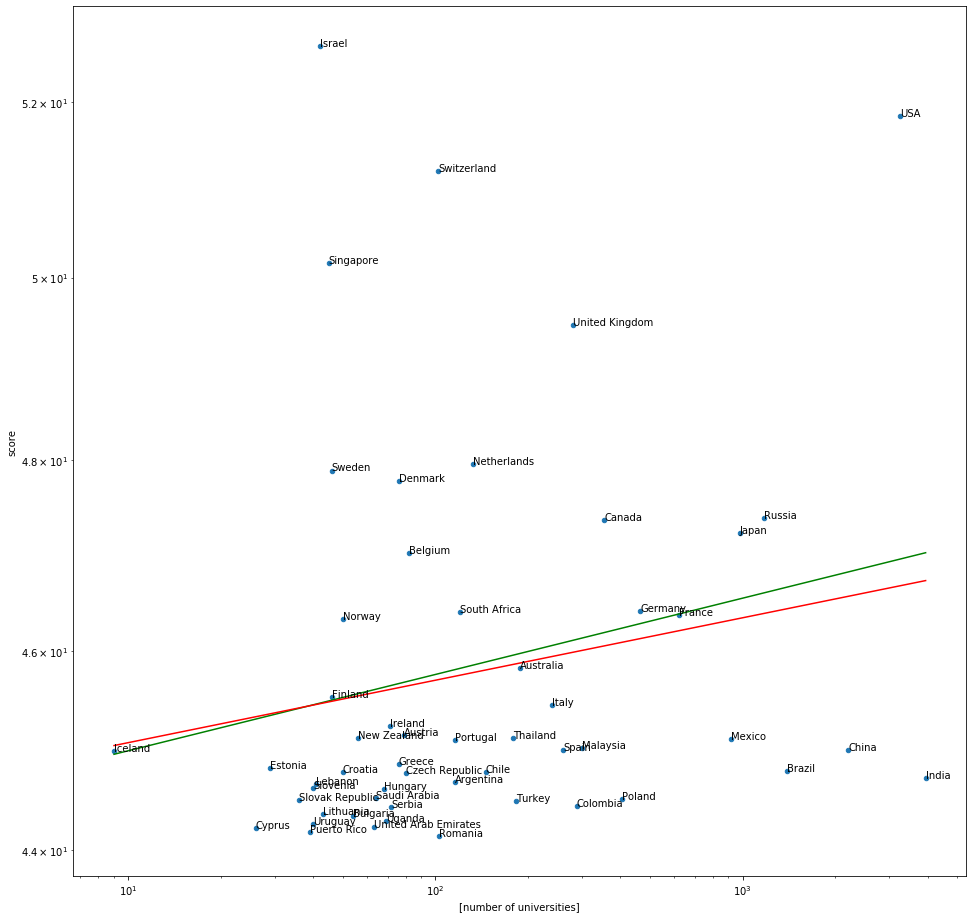

In [33]:
cwur_inh2 = cwur_inh.groupby("country").mean()
cwur_inh2["universities per inhabitant log"] = np.log(cwur_inh2["universities per inhabitant"])
cwur_inh2["inhabitants log"] = np.log(cwur_inh2["inhabitants"])
cwur_inh2["universities log"] = np.log(cwur_inh2["number of universities"])
cwur_inh2["score log"] = np.log(cwur_inh2["score"])


fig, ax = plt.subplots()
cwur_inh2.plot([('number of universities')], "score", kind="scatter",
             figsize = (16,16), ax=ax)


ax.set_xscale('log')
ax.set_yscale('log')

x=np.log(cwur_inh2[("number of universities")])
y=np.log(cwur_inh2["score"])
b, m = polyfit(x,y, 1, w = cwur_inh2["number of universities"])
plt.plot(np.exp(x.sort_values()), np.exp(b + m * x.sort_values()), '-', color="green")
b, m = polyfit(x,y, 1)
plt.plot(np.exp(x.sort_values()), np.exp(b + m * x.sort_values()), '-', color="red")


for k, v in cwur_inh2.iterrows():
    x = v['number of universities']
    y = v["score"]
    ax.annotate(k, (x,y))

plt.show()

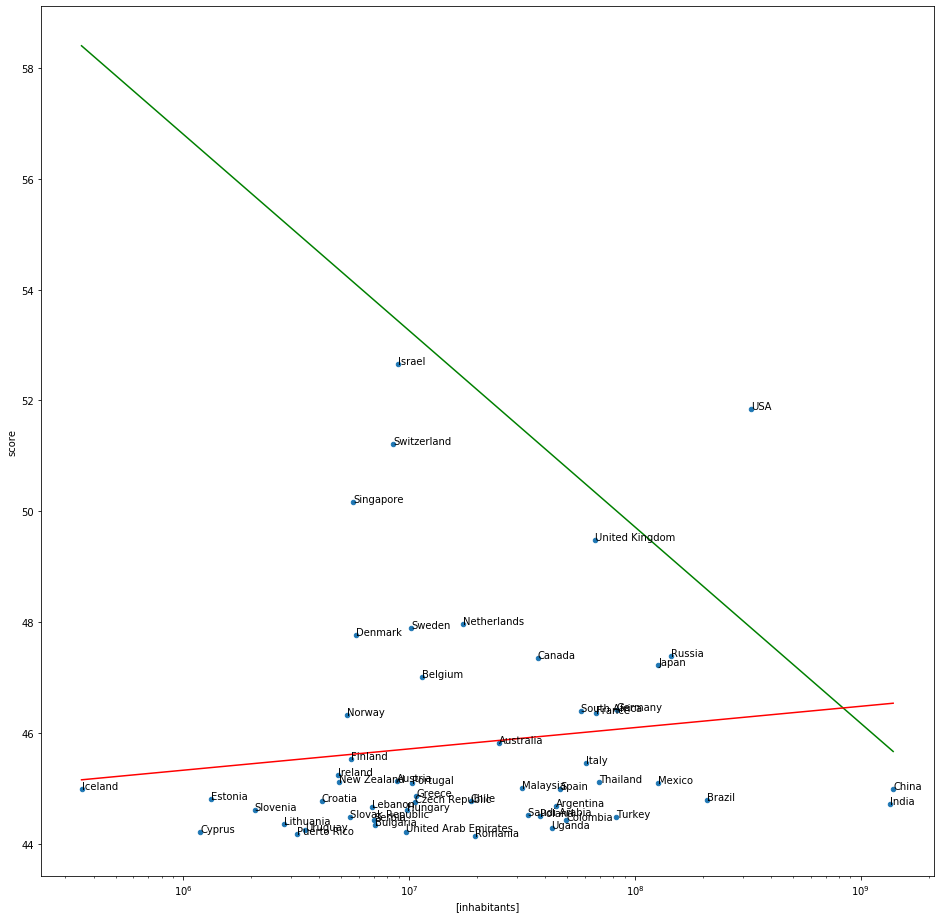

In [34]:
cwur_inh2 = cwur_inh.groupby("country").mean()
fig, ax = plt.subplots()
cwur_inh2.plot([('inhabitants')], "score", kind="scatter",
             figsize = (16,16), ax=ax)
ax.set_xscale('log')
#ax.set_yscale('log')

x=np.log(cwur_inh2[("inhabitants")])
y=cwur_inh2["score"]
b, m = polyfit(x,y, 1, w = cwur_inh2["number of universities"])
plt.plot(np.exp(x.sort_values()), b + m * x.sort_values(), '-', color="green")
b, m = polyfit(x,y, 1)
plt.plot(np.exp(x.sort_values()), b + m * x.sort_values(), '-', color="red")


for k, v in cwur_inh2.iterrows():
    x = v['inhabitants']
    y = v["score"]
    ax.annotate(k, (x,y))

plt.show()

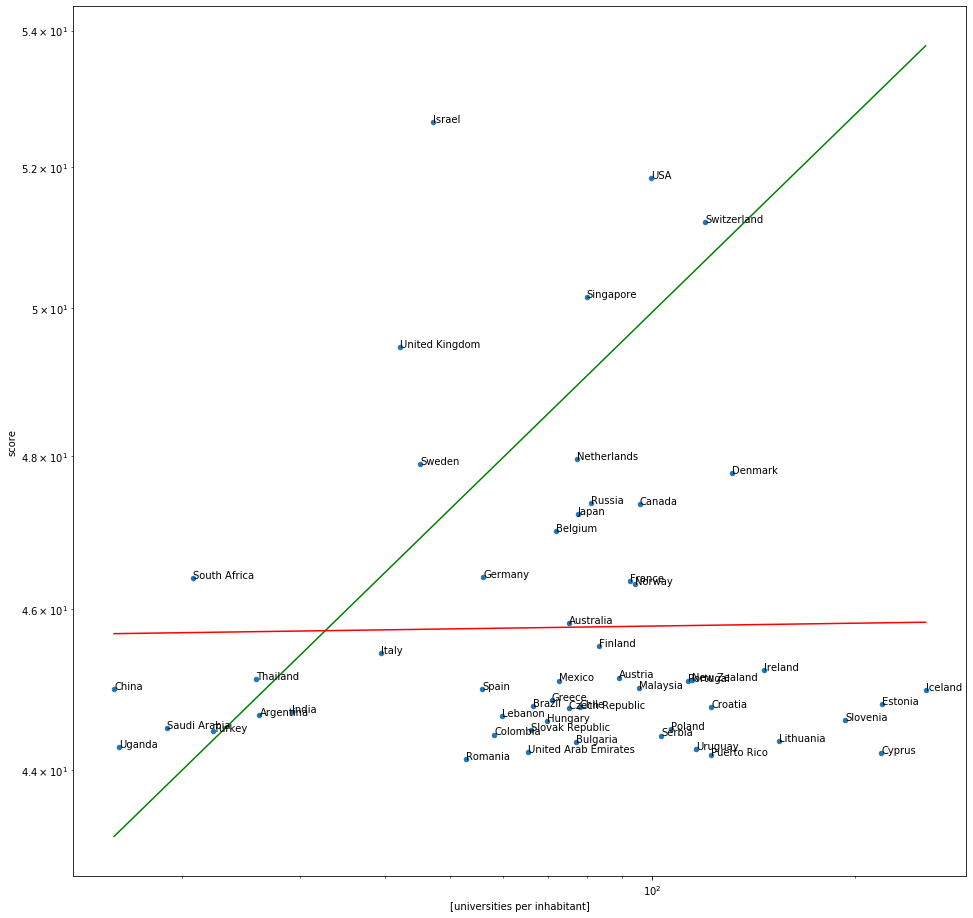

In [35]:
cwur_inh2 = cwur_inh.groupby("country").mean()
fig, ax = plt.subplots()

cwur_inh2.plot([('universities per inhabitant')], "score", kind="scatter",
             figsize = (16,16), ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')

x=np.log(cwur_inh2[("universities per inhabitant")])
y=np.log(cwur_inh2["score"])
# b, m = polyfit(x,y, 1, w = np.log(cwur_inh2["number of universities"]))
b, m = polyfit(x,y, 1, w = cwur_inh2["number of universities"])
plt.plot(np.exp(x.sort_values()),np.exp(b + m * x.sort_values()), '-', color="green")
b, m = polyfit(x,y, 1)
plt.plot(np.exp(x.sort_values()),np.exp(b + m * x.sort_values()), '-', color="red")


for k, v in cwur_inh2.iterrows():
    x = v['universities per inhabitant']
    y = v["score"]
    ax.annotate(k, (x,y))

plt.show()

In [36]:
cwur_inh2["score"].sort_values()

country
Romania                 44.133333
Puerto Rico             44.175000
Cyprus                  44.210000
United Arab Emirates    44.220000
Uruguay                 44.255000
                          ...    
United Kingdom          49.474653
Singapore               50.160000
Switzerland             51.208846
USA                     51.839860
Israel                  52.654091
Name: score, Length: 54, dtype: float64

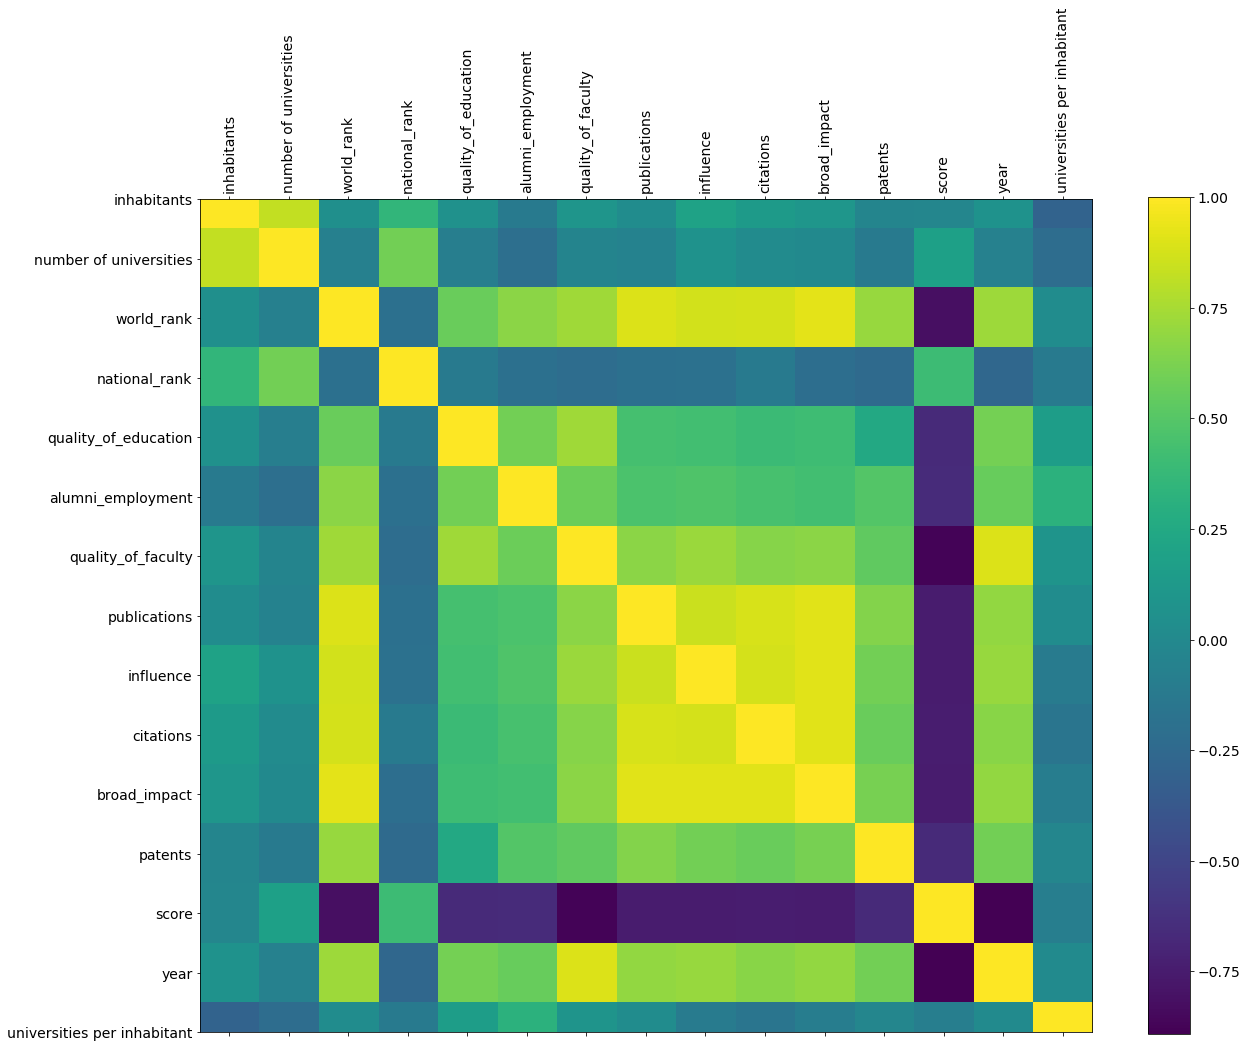

In [37]:
#Heatmap
fig1 = plt.figure(figsize=(20, 15))
plt.matshow(cwur_inh2.corr(), fignum=fig1.number)
plt.xticks(range(cwur_inh2.shape[1]), cwur_inh2.columns, fontsize=14, rotation=90)
plt.yticks(range(cwur_inh2.shape[1]), cwur_inh2.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

#### 3.3.5 Corruption Perceptions Index and rankings by region

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

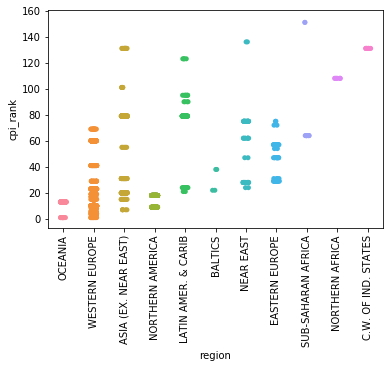

In [38]:
#plot country by region and ranking
sb.stripplot(x="region", y="cpi_rank", data=cwur_cpi_reg, jitter=True)
plt.xticks(rotation=90)

In [39]:
#correlation between corruption preceptions index and university properties
corr = cwur_cpi_reg.corr()
corr.style.background_gradient(cmap='coolwarm')

,cpi_rank,year,cpi_score,world_rank,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score
cpi_rank,1,0.12388,-0.968316,0.393995,-0.17717,0.245182,0.220535,0.260676,0.300245,0.47462,0.389219,0.437357,0.331203,-0.19422
year,0.12388,1,-0.0886936,0.323237,0.106502,0.426295,0.42871,0.484197,0.320094,0.318618,0.329249,0.289979,0.383993,-0.240117
cpi_score,-0.968316,-0.0886936,1,-0.389345,0.170875,-0.250198,-0.221588,-0.250578,-0.286353,-0.47319,-0.395752,-0.428456,-0.311589,0.1864
world_rank,0.393995,0.323237,-0.389345,1,0.24131,0.68485,0.66641,0.671843,0.923435,0.899569,0.860421,0.954139,0.712976,-0.548826
national_rank,-0.17717,0.106502,0.170875,0.24131,1,0.223955,0.138503,0.232482,0.33446,0.1715,0.196223,0.219274,0.147428,-0.202978
quality_of_education,0.245182,0.426295,-0.250198,0.68485,0.223955,1,0.611523,0.783667,0.62908,0.644739,0.63147,0.612731,0.560986,-0.603562
alumni_employment,0.220535,0.42871,-0.221588,0.66641,0.138503,0.611523,1,0.562146,0.566066,0.52094,0.554144,0.519761,0.546488,-0.508126
quality_of_faculty,0.260676,0.484197,-0.250578,0.671843,0.232482,0.783667,0.562146,1,0.639593,0.657443,0.654615,0.634172,0.583842,-0.696436
publications,0.300245,0.320094,-0.286353,0.923435,0.33446,0.62908,0.566066,0.639593,1,0.874442,0.829647,0.92932,0.693715,-0.520818
influence,0.47462,0.318618,-0.47319,0.899569,0.1715,0.644739,0.52094,0.657443,0.874442,1,0.842439,0.928032,0.647137,-0.52124


## Step 4: Model the data

In [40]:
hdi_score = cwur_hdi_mean[[ 'hdi', 'world_rank']]


#encode categorical variable for model training
#hdi_score['institution']  = encInst.transform(hdi_score['institution'])
#hdi_score['country'] =  encCon.transform(hdi_score['country'])

# y is the actual data we want to predict
y = np.array(hdi_score['world_rank'])

#drop data we want to predict from table
x= hdi_score.drop(('world_rank'), axis = 1)

# Convert to numpy array
x = np.array(x)

# Save feature names for visualization later
feature_list = list(hdi_score.columns)

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.8, random_state = 101)

print('Training Features Shape:', train_x.shape)
print('Training Labels Shape:', train_y.shape)
print('Testing Features Shape:', test_x.shape)
print('Testing Labels Shape:', test_y.shape)
#hdi_score

Training Features Shape: (29, 1)
Training Labels Shape: (29,)
Testing Features Shape: (119, 1)
Testing Labels Shape: (119,)


In [41]:
#train model

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

#fit model
rf.fit(train_x, train_y)


#predict
pred = rf.predict(test_x)

In [42]:
#check performance metrics


error = abs(pred - test_y)

#calculate mean error to see how much our average estimate is off by
print('Mean Absolute Error:', round(np.mean(error), 2), 'degrees.')
rf.score(pred.reshape(-1,1),test_y.reshape(-1,1))





Mean Absolute Error: 188.35 degrees.


-1.2336424711648108

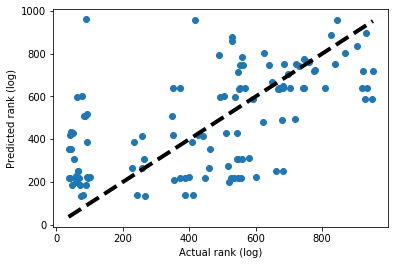

In [43]:
fig, ax = plt.subplots()
ax.scatter(test_y, pred)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=4)
ax.set_xlabel('Actual rank (log)')
ax.set_ylabel('Predicted rank (log)')
plt.show()


In [44]:
times

,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year
0,1,Harvard University,USA,99.7,72.4,98.7,98.8,34.5,96.1,"20,152",8.9,25%,NaN,2011
1,2,California Institute of Technology,USA,97.7,54.6,98.0,99.9,83.7,96.0,"2,243",6.9,27%,33 : 67,2011
2,3,Massachusetts Institute of Technology,USA,97.8,82.3,91.4,99.9,87.5,95.6,"11,074",9.0,33%,37 : 63,2011
3,4,Stanford University,USA,98.3,29.5,98.1,99.2,64.3,94.3,"15,596",7.8,22%,42 : 58,2011
4,5,Princeton University,USA,90.9,70.3,95.4,99.9,-,94.2,"7,929",8.4,27%,45 : 55,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2598,700,Yeungnam University,South Korea,18.6,24.3,10.9,26.5,35.4,-,"21,958",15.3,3%,48 : 52,2016
2599,700,Yıldız Technical University,Turkey,14.5,14.9,7.6,19.3,44.0,-,"31,268",28.7,2%,36 : 64,2016
2600,700,Yokohama City University,Japan,24.0,16.1,10.2,36.4,37.9,-,"4,122",3.7,3%,NaN,2016
2601,700,Yokohama National University,Japan,20.1,23.3,16.0,13.5,40.4,-,"10,117",12.1,8%,28 : 72,2016


In [45]:
times = times.dropna()
times= times[['num_students', 'total_score']]
times['num_students'] = times['num_students'].replace(",", ".")
times['num_students'] = pd.to_numeric(times['num_students'])
display(times['total_score'])
#= pd.to_numeric(times['total_score'])
#times[times.num_students.str.contains('[^0-9]' ,regex = True)]['num_students'].unique()




ValueError: Unable to parse string "2,243" at position 0

In [ ]:
#times.plot('total_score', 'num_students')
plt.scatter(times['total_score'], times['num_students'])
plt.show()